In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time, sys, os

directory = 'figures'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.rcParams['figure.dpi']=400

## Hamiltonian

In [2]:
def denseH(L, J, hx, hz, periodic):
    """
    generates the dense Hamiltonian matrix for the quantum Ising chain with both transverse and longitudinal magnetic fields
    
        Parameters:
            L (int): length of chain
            J (float): ising interaction strength
            h (float): magnetic field strength
            periodic (bool): does the chain have periodic boundary conditions?
            
        Returns:
            H (ndarray): 2^L x 2^L matrix representing the Hamiltonian operator
    """

    dim=2 ** L # dimensions of the Hilbert space
    
    H = np.zeros((dim, dim)) # initliaze the Hamiltonian
    
    "Calculation of off-diagonal elements due to the magnetic field"
    
    for beta in range(dim): # iterate over all states
        
        for j in range(1,L+1): # iterate over all sites
            
            alpha = beta ^ (1<<j-1) # flips jth bit of beta to get the state alpha that is related to beta by a single bit flip
            
            H[alpha, beta] -= hx # contribution by sigma^j_x
            
    "Calculation of diagonal elements due to Ising interaction"

    for alpha in range(dim): # iterate over all states
        
        for j in range(1, L): # iterate over all sites
            
            if 2*(alpha & (1 << j-1)) == alpha & (1 << j): # check if site j and j+1 have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
            
        "Diagonal elements due to longitudinal magnetic field"
        
        for j in range(1, L+1):
            
            if alpha & (1 << (j-1)) == 0:  # check if the spin at site j is up
                H[alpha, alpha] -= hz  # decrease energy for spin up
                
            else:
                H[alpha, alpha] += hz  # increase energy for spin down

        
        "Handling case of periodic boundary conditions"
                
        if periodic and L > 1: # L > 1 needed for periodicity to mean anything
            
            if (alpha & (1 << L-1)) == ((alpha & (1 << 0))*(2**(L-1))): # Check if the states at either end have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
                
    return H   

## Useful troubleshooting code

In [3]:
def mps(psi, k):

    # Converts a wavefunction into mps form
    
    mps_tensors = []
    L = int(np.log2(len(psi)))  # Number of spins/sites
    psi_matrix = psi.reshape(2, 2**(L-1))

    for i in range(L-1):
        
        U, S, Vh = np.linalg.svd(psi_matrix, full_matrices=False)
        
        chi = min(k, len(S))
        
        S_truncated = S[: chi]
        U_truncated = U[:, :chi]
        Vh_truncated = Vh[:chi, :]

        mps_tensors.append(U_truncated.reshape((-1, 2, chi)))

        if i < L - 2:
            psi_matrix = (np.diag(S_truncated) @ Vh_truncated).reshape(2*chi, -1)
            
        else:
            last_tensor = (np.diag(S_truncated) @ Vh_truncated)
            mps_tensors.append(last_tensor.reshape(chi, 2, -1))

    return mps_tensors

def contract_mps_tensors(mps_tensors):

    # converts mps tensor form to a usual column vector wave-function.
    
    state = mps_tensors[0]
    
    for tensor in mps_tensors[1:]: 
        state = np.einsum('ijk,kln->ijln', state, tensor).reshape(1, -1, tensor.shape[2])
        
    return state.reshape(-1)

## Inner product of MPS

In [4]:
def inner_product(bra, ket):

    # function to output <psi|psi> when given in MPS form 
    
    result = np.einsum('jkl,mkn->ln', bra[0].conj(), ket[0])
    
    for i in range(1, len(ket)):

        A = np.einsum('jkl,mkn->jmln', bra[i].conj(), ket[i])
        result = np.einsum('jm,jmln->ln', result, A)
    
    return result.reshape(-1)[0]

## Function to calculate expectation value of Energy in MPS

In [5]:
def magnetic_term(ket, hx, hz):
    
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    
    L = len(ket)
    results = np.zeros(L, dtype = complex)
    
    for i in range(L):
        
        Hket = [np.copy(k) for k in ket]
    
        Hket[i] = hx*np.einsum('ij,kjm->kim', X, ket[i]) + hz*np.einsum('ij,kjm->kim', Z, ket[i])
        
        results[i] = inner_product(ket, Hket)
        
    return np.sum(results)
        

def ising_term(ket):
    
    Z = np.array([[1,0],[0,-1]])
    L = len(ket)
    results = np.zeros(L, dtype = complex)
    
    for i in range(0, L-1):
        
        Hket = [np.copy(k) for k in ket]
        
        Hket[i] = np.einsum('ij,kjm->kim', Z, ket[i])
        
        Hket[i+1] = np.einsum('ij,kjm->kim', Z, ket[i+1])
        
        results[i] = inner_product(ket, Hket)
        
    return np.sum(results)

def expectation_value_energy(ket, hx, hz, J):
    
    energy = -magnetic_term(ket, hx, hz)-J*ising_term(ket)
    norm = inner_product(ket, ket)
    
    return energy/norm

In [6]:
def local_gate(dt, hx, hz, ket):
    '''
        Applies the local trotter propagators to the MPS and returns the new MPS
    '''

    L = len(ket)

    w = np.array([[-hz, -hx], [-hx, hz]])
    R = scipy.linalg.expm(-1j*dt*w)

    ket_new = []
    
    for i in range(L):
        ket_new.append(np.einsum('ij,kjm->kim', R, ket[i]))

    return ket_new

def twosite_even_gate(dt, J, ket):
    '''
        Applies the even trotter propagators to the MPS and returns the new MPS
    '''

    L = len(ket)

    Z = np.array([[1, 0],[0, -1]])
    H = 1j * dt * J * np.kron(Z, Z)
    T = scipy.linalg.expm(H).reshape(2, 2, 2, 2)

    ket_new = []
    
    for i in range(0, L-1, 2):

        A = np.einsum('ijk,klm->ijlm', ket[i], ket[i+1])
        W = np.einsum('abjl,ijlm->iabm', T, A)
        W = W.reshape(W.shape[0]*W.shape[1], -1)

        U, S, Vh = np.linalg.svd(W, full_matrices=False)
        
        chi = len(S)
        ket_new.append(U.reshape((-1, 2, chi)))
        ket_new.append((np.diag(S) @ Vh).reshape(chi, 2, -1))

    if L%2 != 0:
        ket_new.append(ket[L-1])
        
        
    return ket_new

def twosite_odd_gate(dt, J, ket):
    '''
        Applies the odd trotter propagators to the MPS and returns the new MPS
    '''

    L = len(ket)

    Z = np.array([[1, 0], [0, -1]])
    H = 1j * dt* J * np.kron(Z, Z)
    T = scipy.linalg.expm(H).reshape(2, 2, 2, 2)

    ket_new = []
    ket_new.append(ket[0])
    
    for i in range(1, L-1, 2):

        A = np.einsum('ijk,klm->ijlm', ket[i], ket[i+1])
        W = np.einsum('abjl,ijlm->iabm', T, A)
        W = W.reshape(W.shape[0]*W.shape[1], -1)

        U, S, Vh = np.linalg.svd(W, full_matrices=False)
        
        chi = len(S)
        ket_new.append(U.reshape((-1, 2, chi)))
        ket_new.append((np.diag(S) @ Vh).reshape(chi, 2, -1))
    
    if L%2 == 0:
        ket_new.append(ket[L-1])
        
    return ket_new

In [7]:
def canonical_converter(mps_tensors):
    '''
        Converts the tensor into canonical form with the orthogonality center at L
    '''
    new_mps_tensors = mps_tensors.copy()
    L = len(new_mps_tensors)

    for i in range(L-1):
        W = np.einsum('ijk,klm->ijlm', new_mps_tensors[i], new_mps_tensors[i+1])
        Wmatrix = W.reshape((W.shape[0]*2, -1))
    
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = len(S)

        U = U[:, :chi]
        new_mps_tensors[i] = U.reshape(-1, 2, chi)
        
        S = np.diag(S[:chi])
        Vh = Vh[:chi, :]

        new_mps_tensors[i+1] = (S @ Vh).reshape(chi, 2, -1)

    return new_mps_tensors

def bond_dimension_conserver(k, canonical_mps):
    '''
        given a canonical MPS it goes from left to right truncating the schmidt values to k at each step
        it stores U, S, Vh at every cut to help speed up calculations
        returns the values at the cuts from right to left
    '''
    truncated_mps = canonical_mps.copy()
    L = len(canonical_mps)
    canonical_tracker=[]
    canonical_tracker2 = []
    
    for i in range(L-1, 0, -1):
                
        W = np.einsum('ijk,klm->ijlm', truncated_mps[i-1], truncated_mps[i])

        Wmatrix = W.reshape((W.shape[0]*2, -1))
        
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = min(k, len(S))
        
        U = U[:, :chi]
        Vh = Vh[:chi, :]
        
        truncated_mps[i] = Vh.reshape(chi, 2, -1)
        
        truncated_mps[i-1] = (U @ np.diag(S[:chi])).reshape(-1, 2, chi)

    canonical_tensors = truncated_mps.copy()
    for i in range(L-1):

        W = np.einsum('ijk,klm->ijlm', canonical_tensors[i], canonical_tensors[i+1])
        Wmatrix = W.reshape((W.shape[0]*2, -1))
    
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = min(k, len(S))
        U = U[:, :chi]
        Vh = Vh[:chi, :]
        canonical_tracker.append([U.reshape(-1, 2, chi), S[:chi], Vh.reshape(chi, 2, -1)])
        canonical_tensors[i+1] = (np.diag(S[:chi])@Vh).reshape(chi, 2, -1)


    return truncated_mps, canonical_tracker
    

### Since we have our MPS in canonical form, we can use it to compute the schmidt values much more efficiently.

In [8]:
def magnetic_term_canonical(canonical_tracker, hx, hz):
    
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])

    L = len(canonical_tracker) + 1
    results = np.zeros(L, dtype = complex)

    for i in range(L-1):

        U = canonical_tracker[i][0]
        S = np.diag(canonical_tracker[i][1])
        Ssq = np.einsum('ij,kj->ik', S.conj(), S)
        # apply X,Z to U
        ZU = np.einsum('ij,kjm->kim', Z, U)
        XU = np.einsum('ij,kjm->kim', X, U)
        # apply S^2 to U
        ZUS = np.einsum('kim,nm->kin', ZU, Ssq)
        XUS = np.einsum('kim,nm->kin', XU, Ssq)
        
        UhZUS = np.einsum('aib,kin->akbn', U.conj(), ZUS)
        UhXUS = np.einsum('aib,kin->akbn', U.conj(), XUS)

        results[i] = -hz*np.einsum('aabb', UhZUS) - hx*np.einsum('aabb', UhXUS)

    Ssq = np.einsum('ij,ik->jk', S.conj(), S)
    Vh = canonical_tracker[L-2][2]
    
    ZVh = np.einsum('ij,kjm->kim', Z, Vh)
    XVh = np.einsum('ij,kjm->kim', X, Vh)
    
    ZVhS = np.einsum('jk,kim->jim', Ssq, ZVh)
    XVhS = np.einsum('jk,kim->jim', Ssq, XVh)
    
    VZVhS = np.einsum('aib,kin->akbn', Vh.conj(), ZVhS)
    VXVhS = np.einsum('aib,kin->akbn', Vh.conj(), XVhS)

    results[L-1] = -hz *np.einsum('aabb', VZVhS) -hx*np.einsum('aabb', VXVhS)
    
    return np.sum(results)/np.sum(Ssq)

def ising_term_canonical(canonical_tracker, J):
    Z = np.array([[1,0],[0,-1]])
    L = len(canonical_tracker) + 1
    results = np.zeros(L, dtype = complex)

    for i in range(L-1):

        U = canonical_tracker[i][0]
        S = np.diag(canonical_tracker[i][1])
        Vh = canonical_tracker[i][2]

        Uh = U.conj()
        V = Vh.conj()

        US = np.einsum('abc,cd->abd', U, S)
        USVh = np.einsum('abd,def->abef', US, Vh)
        UhS = np.einsum('abc,cd->abd', Uh, S)
        UhSV = np.einsum('abd,def->abef', UhS, V)
        
        ZUSVh = np.einsum('ib,abef->aief', Z, USVh)
        ZUSVhZ = np.einsum('je,aief->aijf', Z, ZUSVh)

        UhSV_ZUSVhZ = np.einsum('abcd,ebcf->aedf', UhSV, ZUSVhZ)

        results[i] = -J*np.einsum('aabb', UhSV_ZUSVhZ)

    return np.sum(results)/np.sum(S**2)
        
def expectation_value_energy_canonical(canonical_tracker, hx, hz, J):
    
    return magnetic_term_canonical(canonical_tracker, hx, hz) + ising_term_canonical(canonical_tracker, J)

## Time to put it all together

In [9]:
def trotter_step(dt, J, hx, hz, ket, k):
    
    evolved_ket = canonical_converter(
        twosite_odd_gate(
            dt, J,
            twosite_even_gate(
                dt, J,
                local_gate(dt, hx, hz, ket.copy())
            )
        )
    )


    return bond_dimension_conserver(k, evolved_ket)

def time_evolution(T, J, hx, hz, ket, k, iters):
    
    dt = T/iters
    ket_initial, canonical_tracker =  bond_dimension_conserver(k, ket)
    # energy = expectation_value_energy_canonical(canonical_tracker, hx, hz, J)
    # energies = [energy]
    canonical_trackers = [canonical_tracker]
    evolved_ket = ket.copy()
    
    with tqdm(total=iters, desc="Iterations", unit="step") as pbar:
        for i in range(iters):
            evolved_ket, canonical_tracker = trotter_step(dt, J, hx, hz, evolved_ket, k)
            # energy = expectation_value_energy_canonical(canonical_tracker, hx, hz, J)
            # energies.append(energy)
            canonical_trackers.append(canonical_tracker)
            pbar.update(1)
        
    return evolved_ket, canonical_trackers
        

## Initial Product state

In [10]:
def psi_initial_mps(L):
    
    mps_tensors= []
    
    A = np.zeros((1, 2, 1), dtype = complex)
    A[0, 0, 0] = 1/2
    A[0, 1, 0] = -np.sqrt(3)/2
    
    for i in range(L):
        mps_tensors.append(A)

    return mps_tensors

In [139]:
L = 8
J = 1
hx = -1.05
hz = 0.5
periodic = False 
dt = 0.01
t = 100
chi = 16

ket = psi_initial_mps(L)
evolved_ket, energies, canonical_trackers = time_evolution(t, J, hx, hz, ket, chi, int(t/dt))



Iterations: 100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 212.95step/s]


In [161]:
eps = np.array([[1/2],[-np.sqrt(3)/2]])
H = denseH(L, J, hx, hz, periodic)
def psi_initial(L):

    psi_0 = eps
    for _ in range(1, L):
        psi_0 = np.kron(psi_0, eps)
    
    return psi_0
    
Z = np.array([[1, 0], [0, -1]])   
for i in range(L-1):
    Z = np.kron(Z, np.eye(2))
psi = psi_initial(L)
observables = []
observable = (psi.conj().T @ Z @ psi)/np.linalg.norm(psi)
observables.append(observable.flatten()[0])
dt = t/100
for i in range(100):
    psi = (scipy.linalg.expm(-1j*dt*H) @ psi).reshape(-1)
    observable = (psi.conj().T @ Z @ psi)/np.linalg.norm(psi)
    observables.append(observable)
    

len(observables)

101

In [162]:
print(observables)

[-0.49999999999999983, (0.13143724225403233+0j), (0.2753586754794626+0j), (0.14633356966646152+0j), (-0.006605677351220642+0j), (0.06275127953895561+0j), (0.04672800960377179+0j), (0.22736671296693284+0j), (0.1612904576334697+0j), (0.39373589852895685+0j), (0.2649958421349876+0j), (0.021923135570596164+0j), (0.3420693439081783+0j), (-0.042073415804043716+0j), (0.2309415205124439+0j), (-0.08093814235198683+0j), (0.08607786926993481+0j), (0.27841814460884007+0j), (0.3093785261632555+0j), (0.21921760129725318+0j), (0.22576274449824738+0j), (0.249393330526849+0j), (0.1385128847677515+0j), (0.162001264848231+0j), (0.15678062922812136+0j), (0.3872986469096483+0j), (0.12685762472195442+0j), (0.3070824800864259+0j), (0.2899420559822311+0j), (-0.005232105561942389+0j), (-0.19077468364324243+0j), (0.2556501572780975+0j), (0.16556196782255816+0j), (0.2844692544719756+0j), (-0.04839967820759699+0j), (-0.028363211210176598+0j), (0.13885600659123926+0j), (0.11837015379499528+0j), (0.1441192711526658

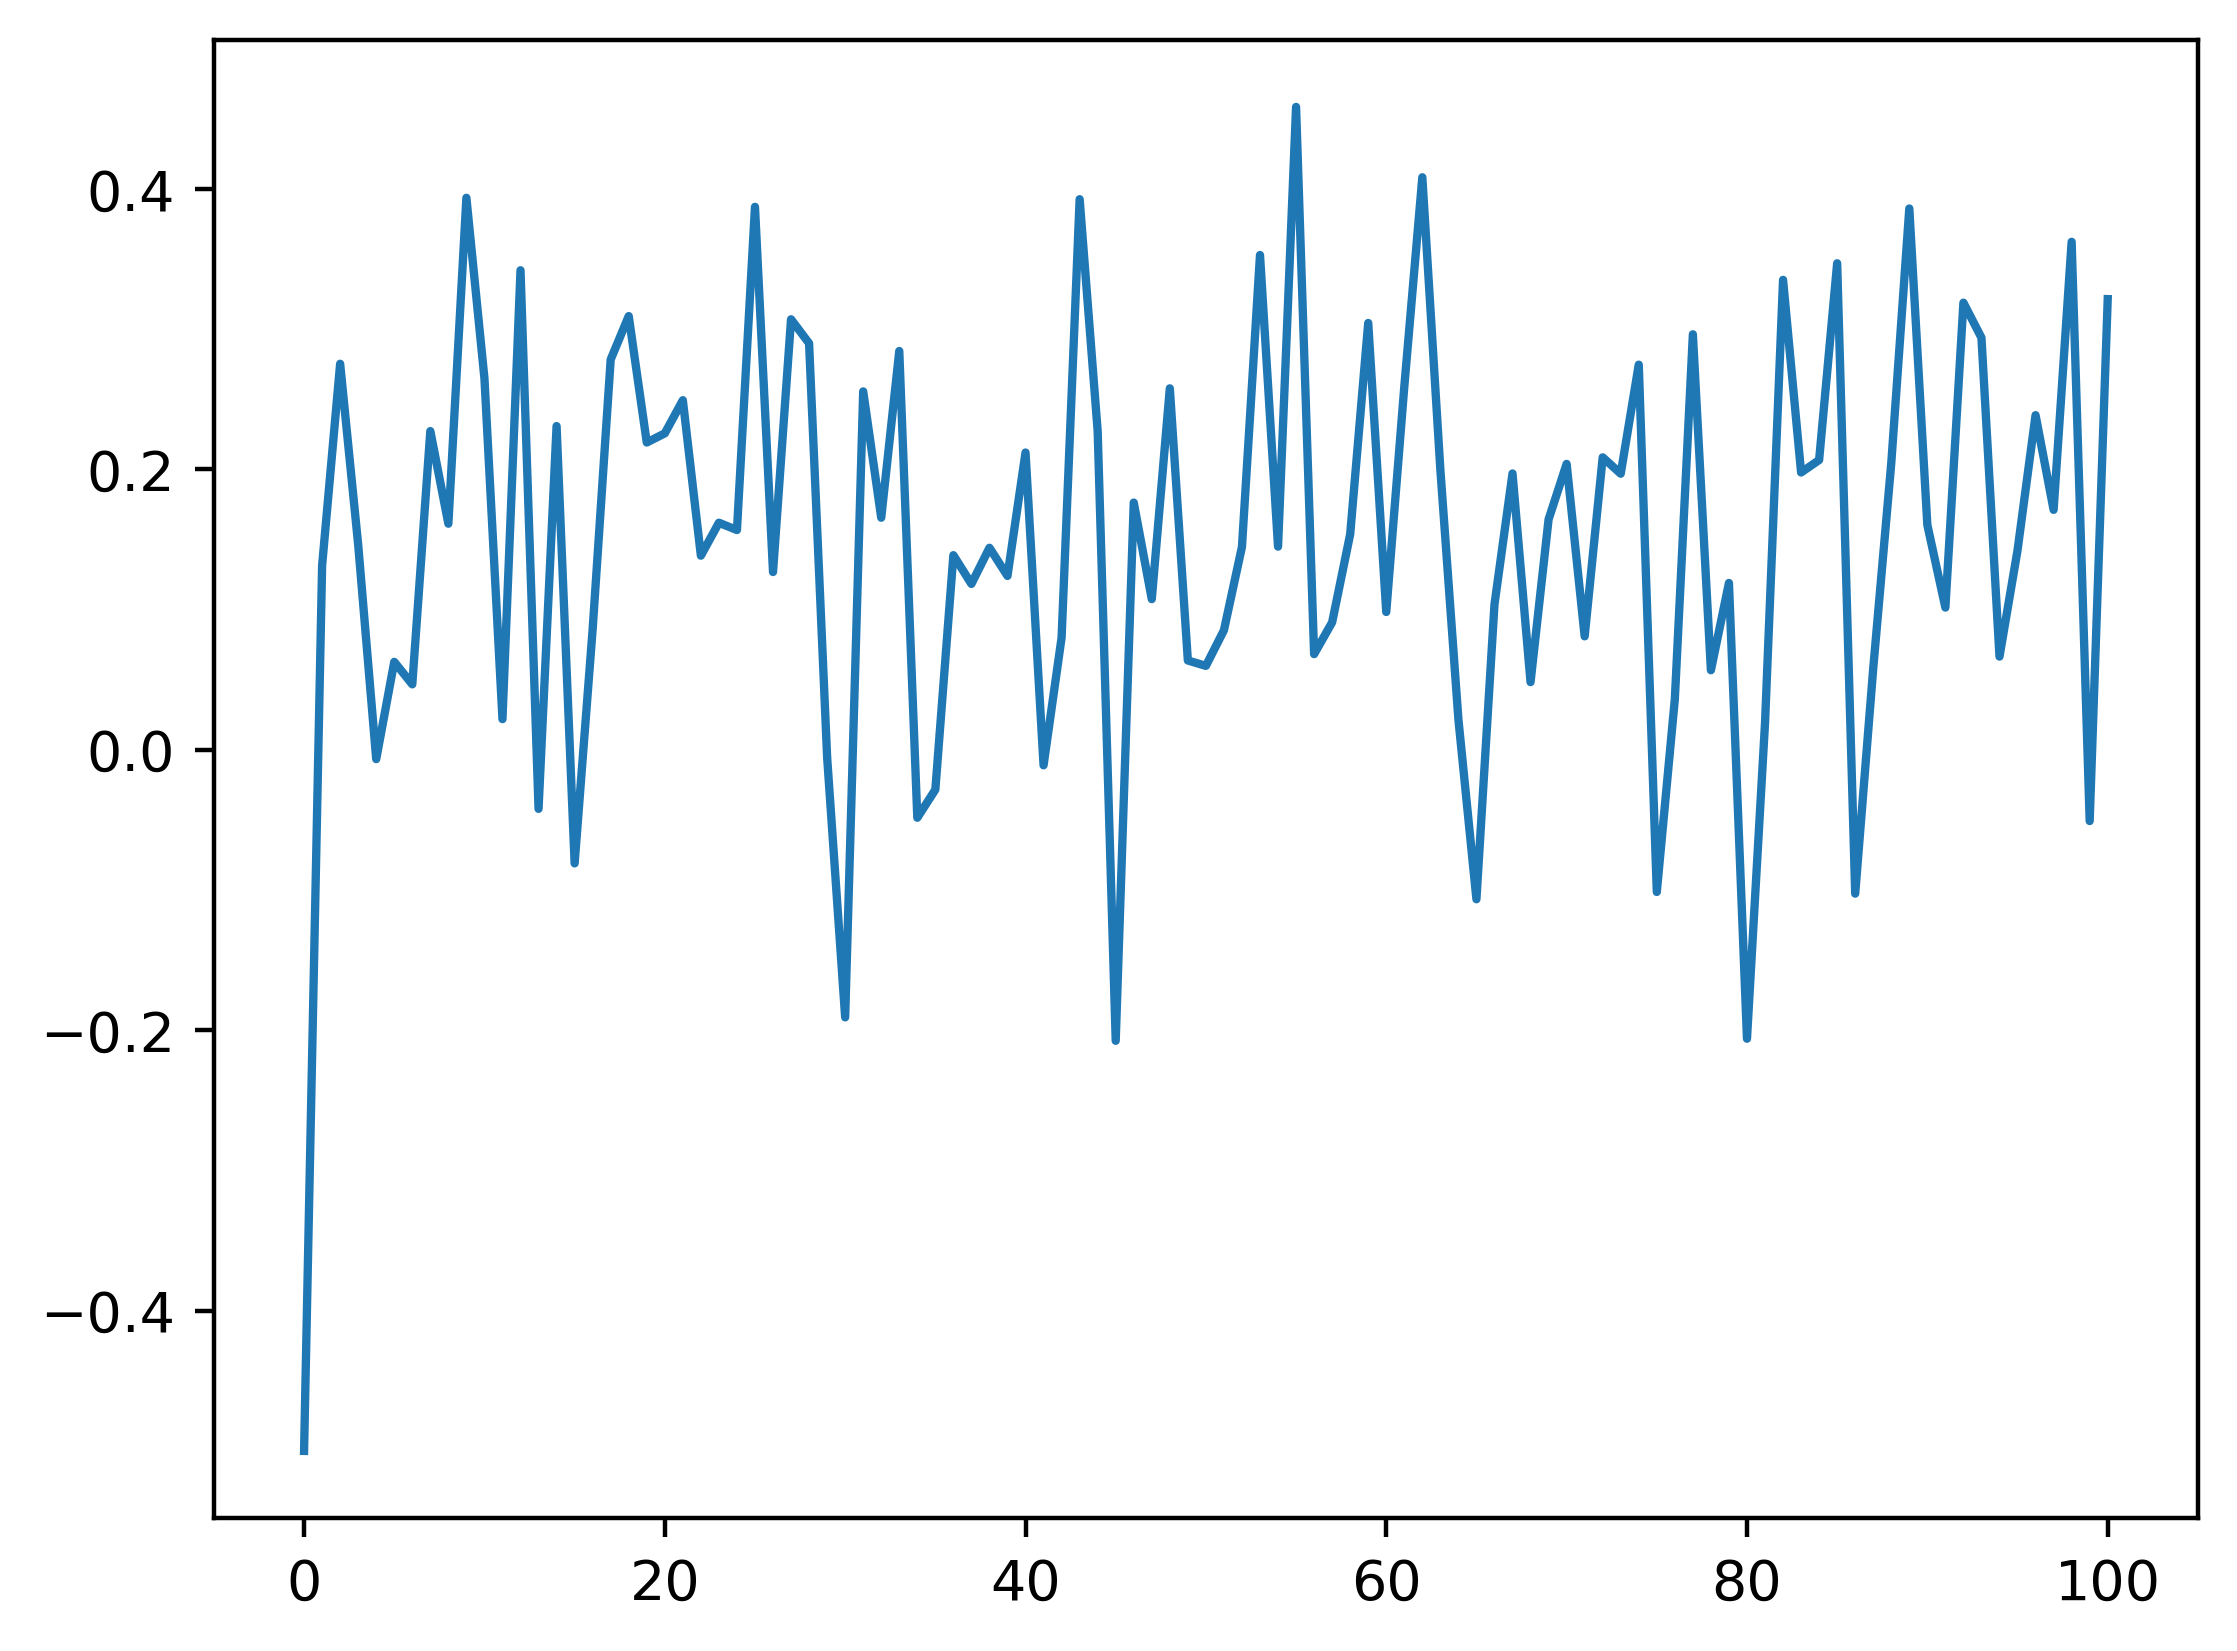

In [163]:
plt.plot(np.arange(0, 101, 1), observables)

In [118]:
ket = psi_initial_mps(L)
evolved_ket, energies, canonical_trackers = time_evolution(t, J, hx, hz, ket, chi, 1000)


Iterations: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.90step/s]


In [125]:
psi2 = contract_mps_tensors(evolved_ket)

In [127]:
are_close = np.allclose(psi.flatten(), psi2, atol=1e-3) 

print("Are the vectors close:", are_close)

Are the vectors close: True


## Observables

In [42]:
L = 14
J = 1
hx = -1.05
hz = 0.5
periodic = False 
dt = 0.01
t = 10
chi = 16

ket = psi_initial_mps(L)
evolved_ket1, canonical_trackers1 = time_evolution(t, J, hx, hz, ket, 16, int(t/dt))
evolved_ket21, canonical_trackers21 = time_evolution(t, J, hx, hz, ket, 32, int(t/dt))
evolved_ket31, canonical_trackers31 = time_evolution(t, J, hx, hz, ket, 64, int(t/dt))
evolved_ket41, canonical_trackers41 = time_evolution(t, J, hx, hz, ket, 128, int(t/dt))




Iterations: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [07:49<00:00,  2.13step/s]


In [45]:
evolved_ket51, canonical_trackers51 = time_evolution(t, J, hx, hz, ket, 4, int(t/dt))
evolved_ket61, canonical_trackers61 = time_evolution(t, J, hx, hz, ket, 8, int(t/dt))

Iterations: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [01:28<00:00, 11.32step/s]


In [49]:
evolved_ket71, canonical_trackers71 = time_evolution(t, J, hx, hz, ket, 2, int(t/dt))

Iterations: 100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.47step/s]


In [27]:
def expectation_value_Cz(r, canonical_tracker):

    Z = np.array([[1, 0], [0, -1]])
    # r neq L
    U = canonical_tracker[r][0]
    S = np.diag(canonical_tracker[r][1])
    Ssq = np.einsum('ij,kj->ik', S.conj(), S)
    ZU = np.einsum('ij,kjm->kim', Z, U)
    ZUS = np.einsum('kim,nm->kin', ZU, Ssq)
    UhZUS = np.einsum('aib,kin->akbn', U.conj(), ZUS)
    
    return np.einsum('aabb', UhZUS)/(np.sum(Ssq))

In [28]:
def expectation_value_Cx(r, canonical_tracker):
    
    X = np.array([[0, 1], [1, 0]])
    # r neq L
    U = canonical_tracker[r][0]
    S = np.diag(canonical_tracker[r][1])
    Ssq = np.einsum('ij,kj->ik', S.conj(), S)
    XU = np.einsum('ij,kjm->kim', X, U)
    XUS = np.einsum('kim,nm->kin', XU, Ssq)
    UhXUS = np.einsum('aib,kin->akbn', U.conj(), XUS)

    return np.einsum('aabb', UhXUS)/(np.sum(Ssq))
    

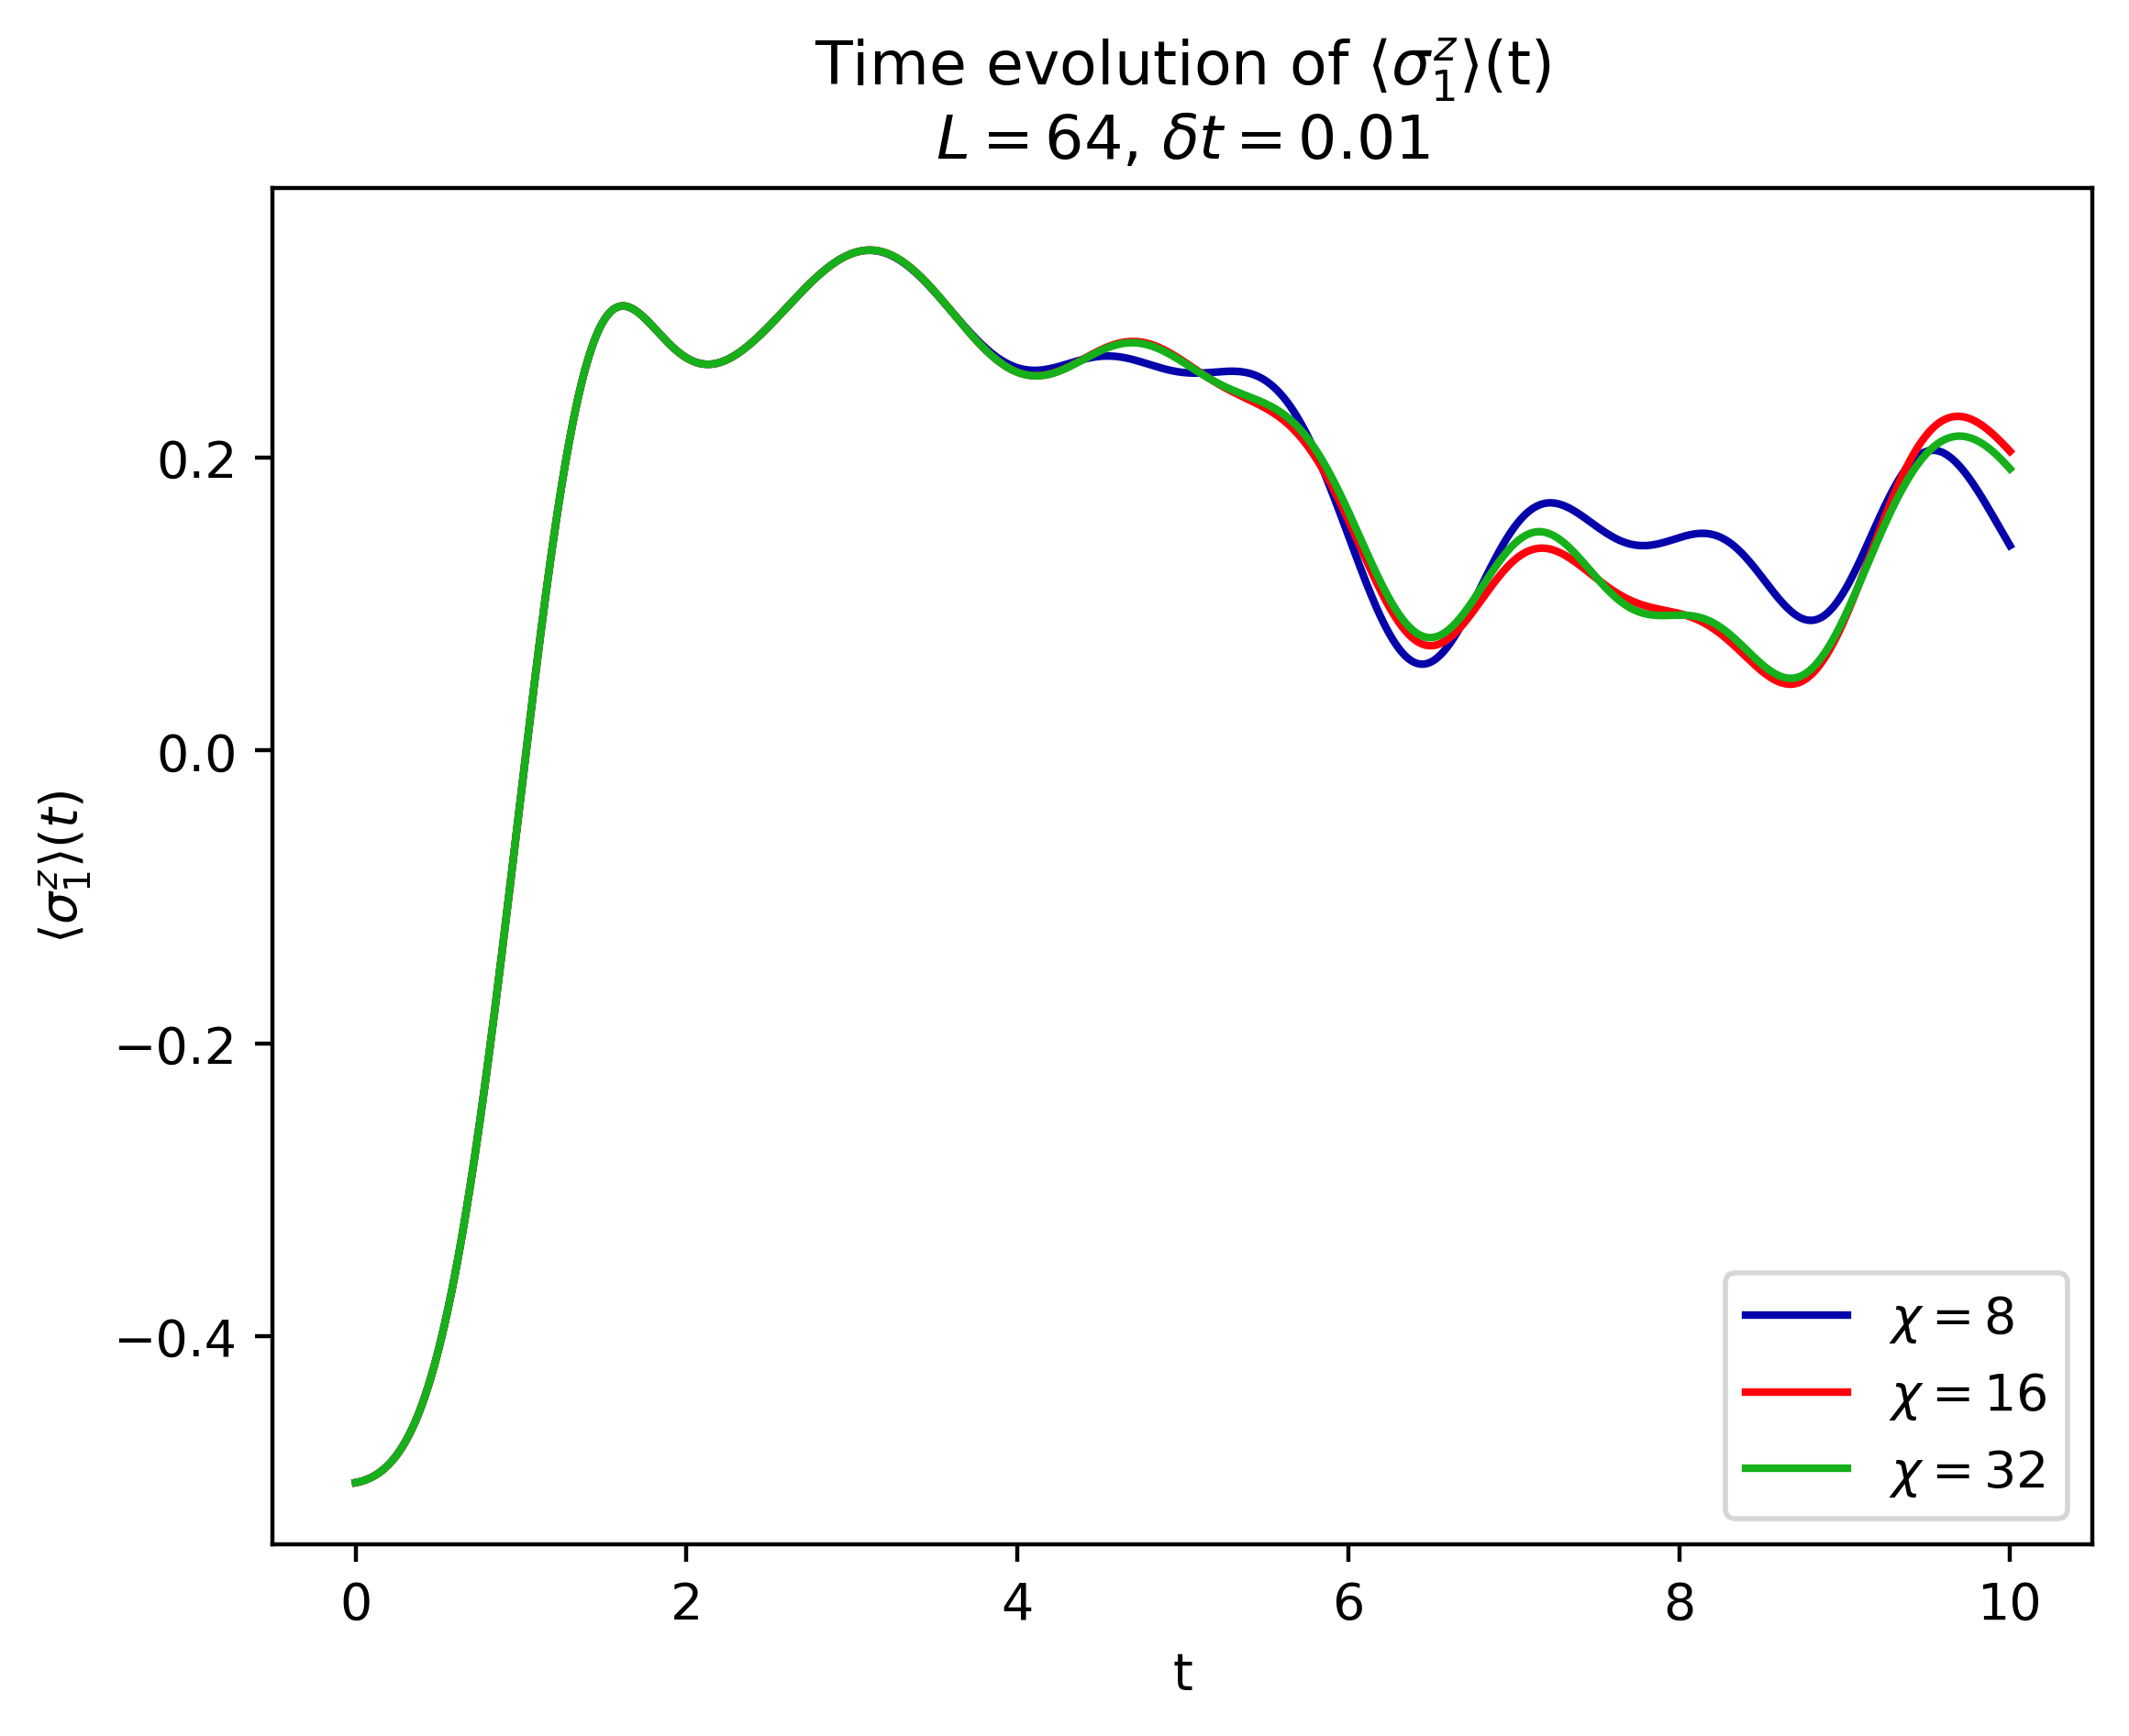

In [29]:
observables = []
observables_2 = []
observables_3 = []
for i in range(len(canonical_trackers)):
    observable = expectation_value_Cz(1, canonical_trackers[i])
    observables.append(observable)
    
    observable = expectation_value_Cz(1, canonical_trackers2[i])
    observables_2.append(observable)

    observable = expectation_value_Cz(1, canonical_trackers3[i])
    observables_3.append(observable)

plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_3, color='xkcd:royal blue', label=r'$\chi=8$')  
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables, color='xkcd:bright red', label=r'$\chi=16$')
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_2, color='xkcd:green', label=r'$\chi=32$')

plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^z_{1}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^z_{1}\rangle$(t)'+'\n$L = 64$, $\delta t = 0.01$')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmazp2new.png'), dpi=400)
plt.show()

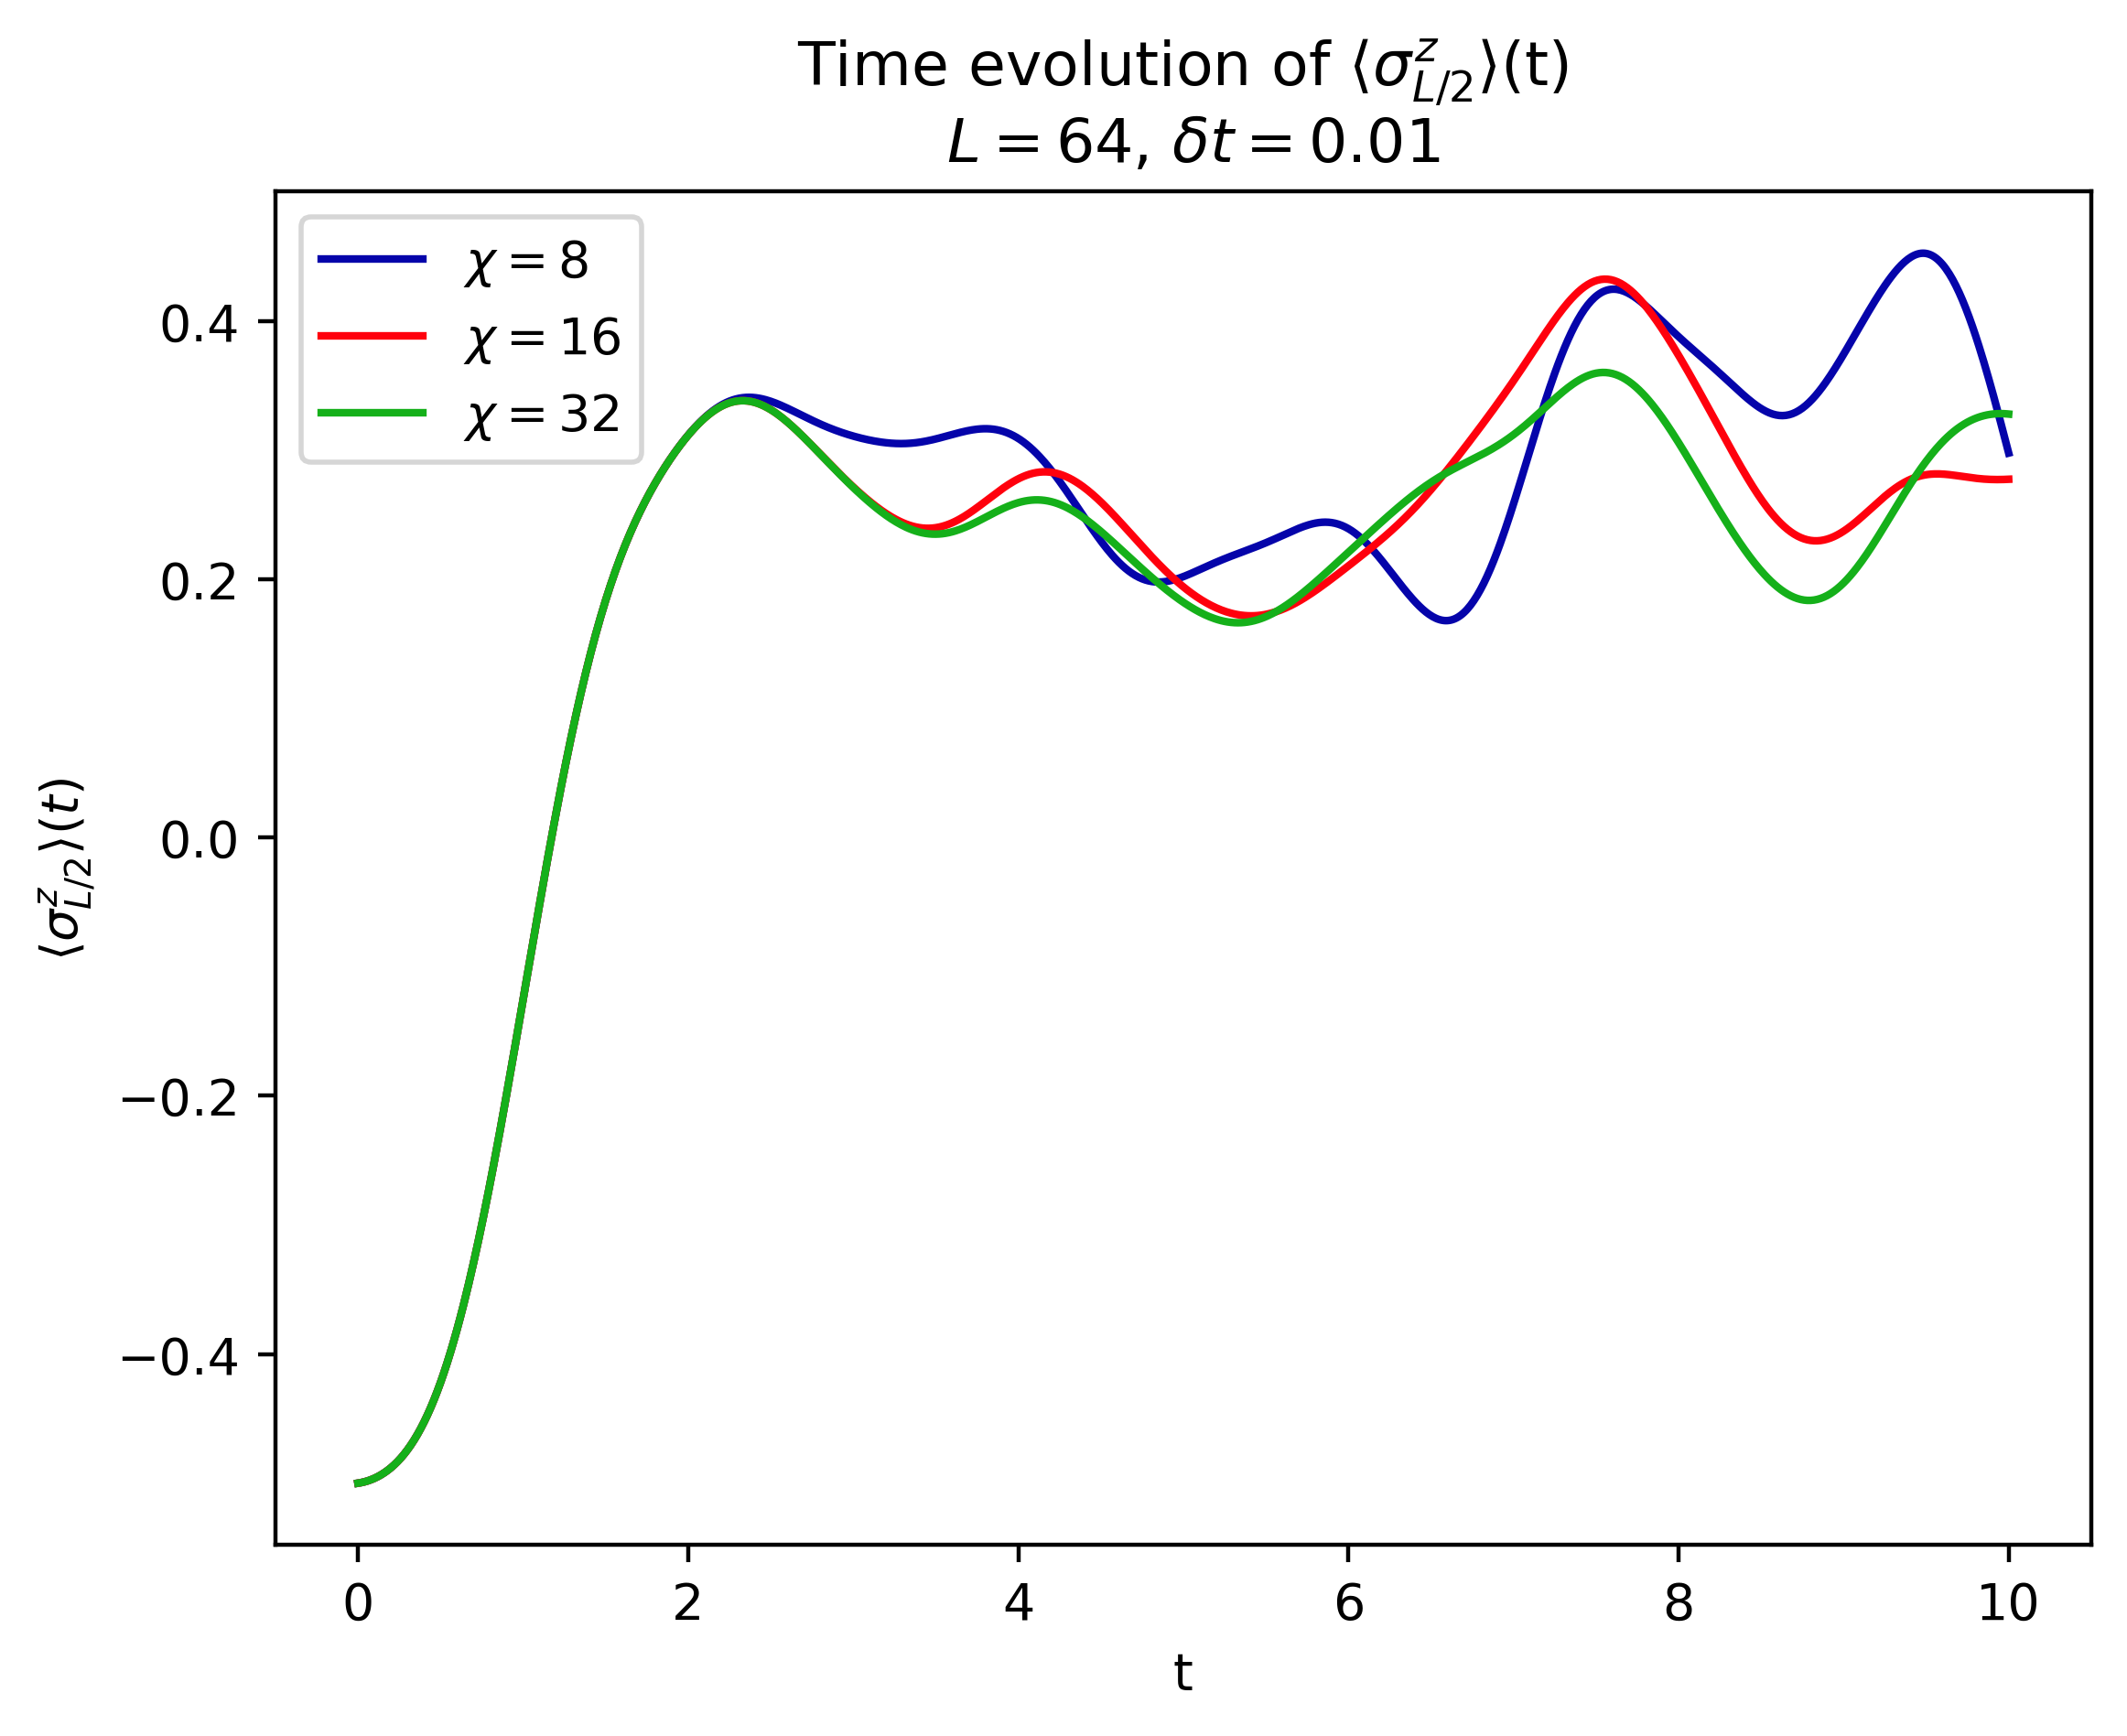

In [32]:
observables = []
observables_2 = []
observables_3 = []
for i in range(len(canonical_trackers)):
    observable = expectation_value_Cz(L//2, canonical_trackers[i])
    observables.append(observable)
    
    observable = expectation_value_Cz(L//2, canonical_trackers2[i])
    observables_2.append(observable)

    observable = expectation_value_Cz(L//2, canonical_trackers3[i])
    observables_3.append(observable)

    
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_3, color='xkcd:royal blue', label=r'$\chi=8$')  
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables, color='xkcd:bright red', label=r'$\chi=16$')
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_2, color='xkcd:green', label=r'$\chi=32$')
         
plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^z_{L/2}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^z_{L/2}\rangle$(t)'+'\n $L = 64$, $\delta t = 0.01$')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmazp2middlenew.png'), dpi=400)
plt.show()

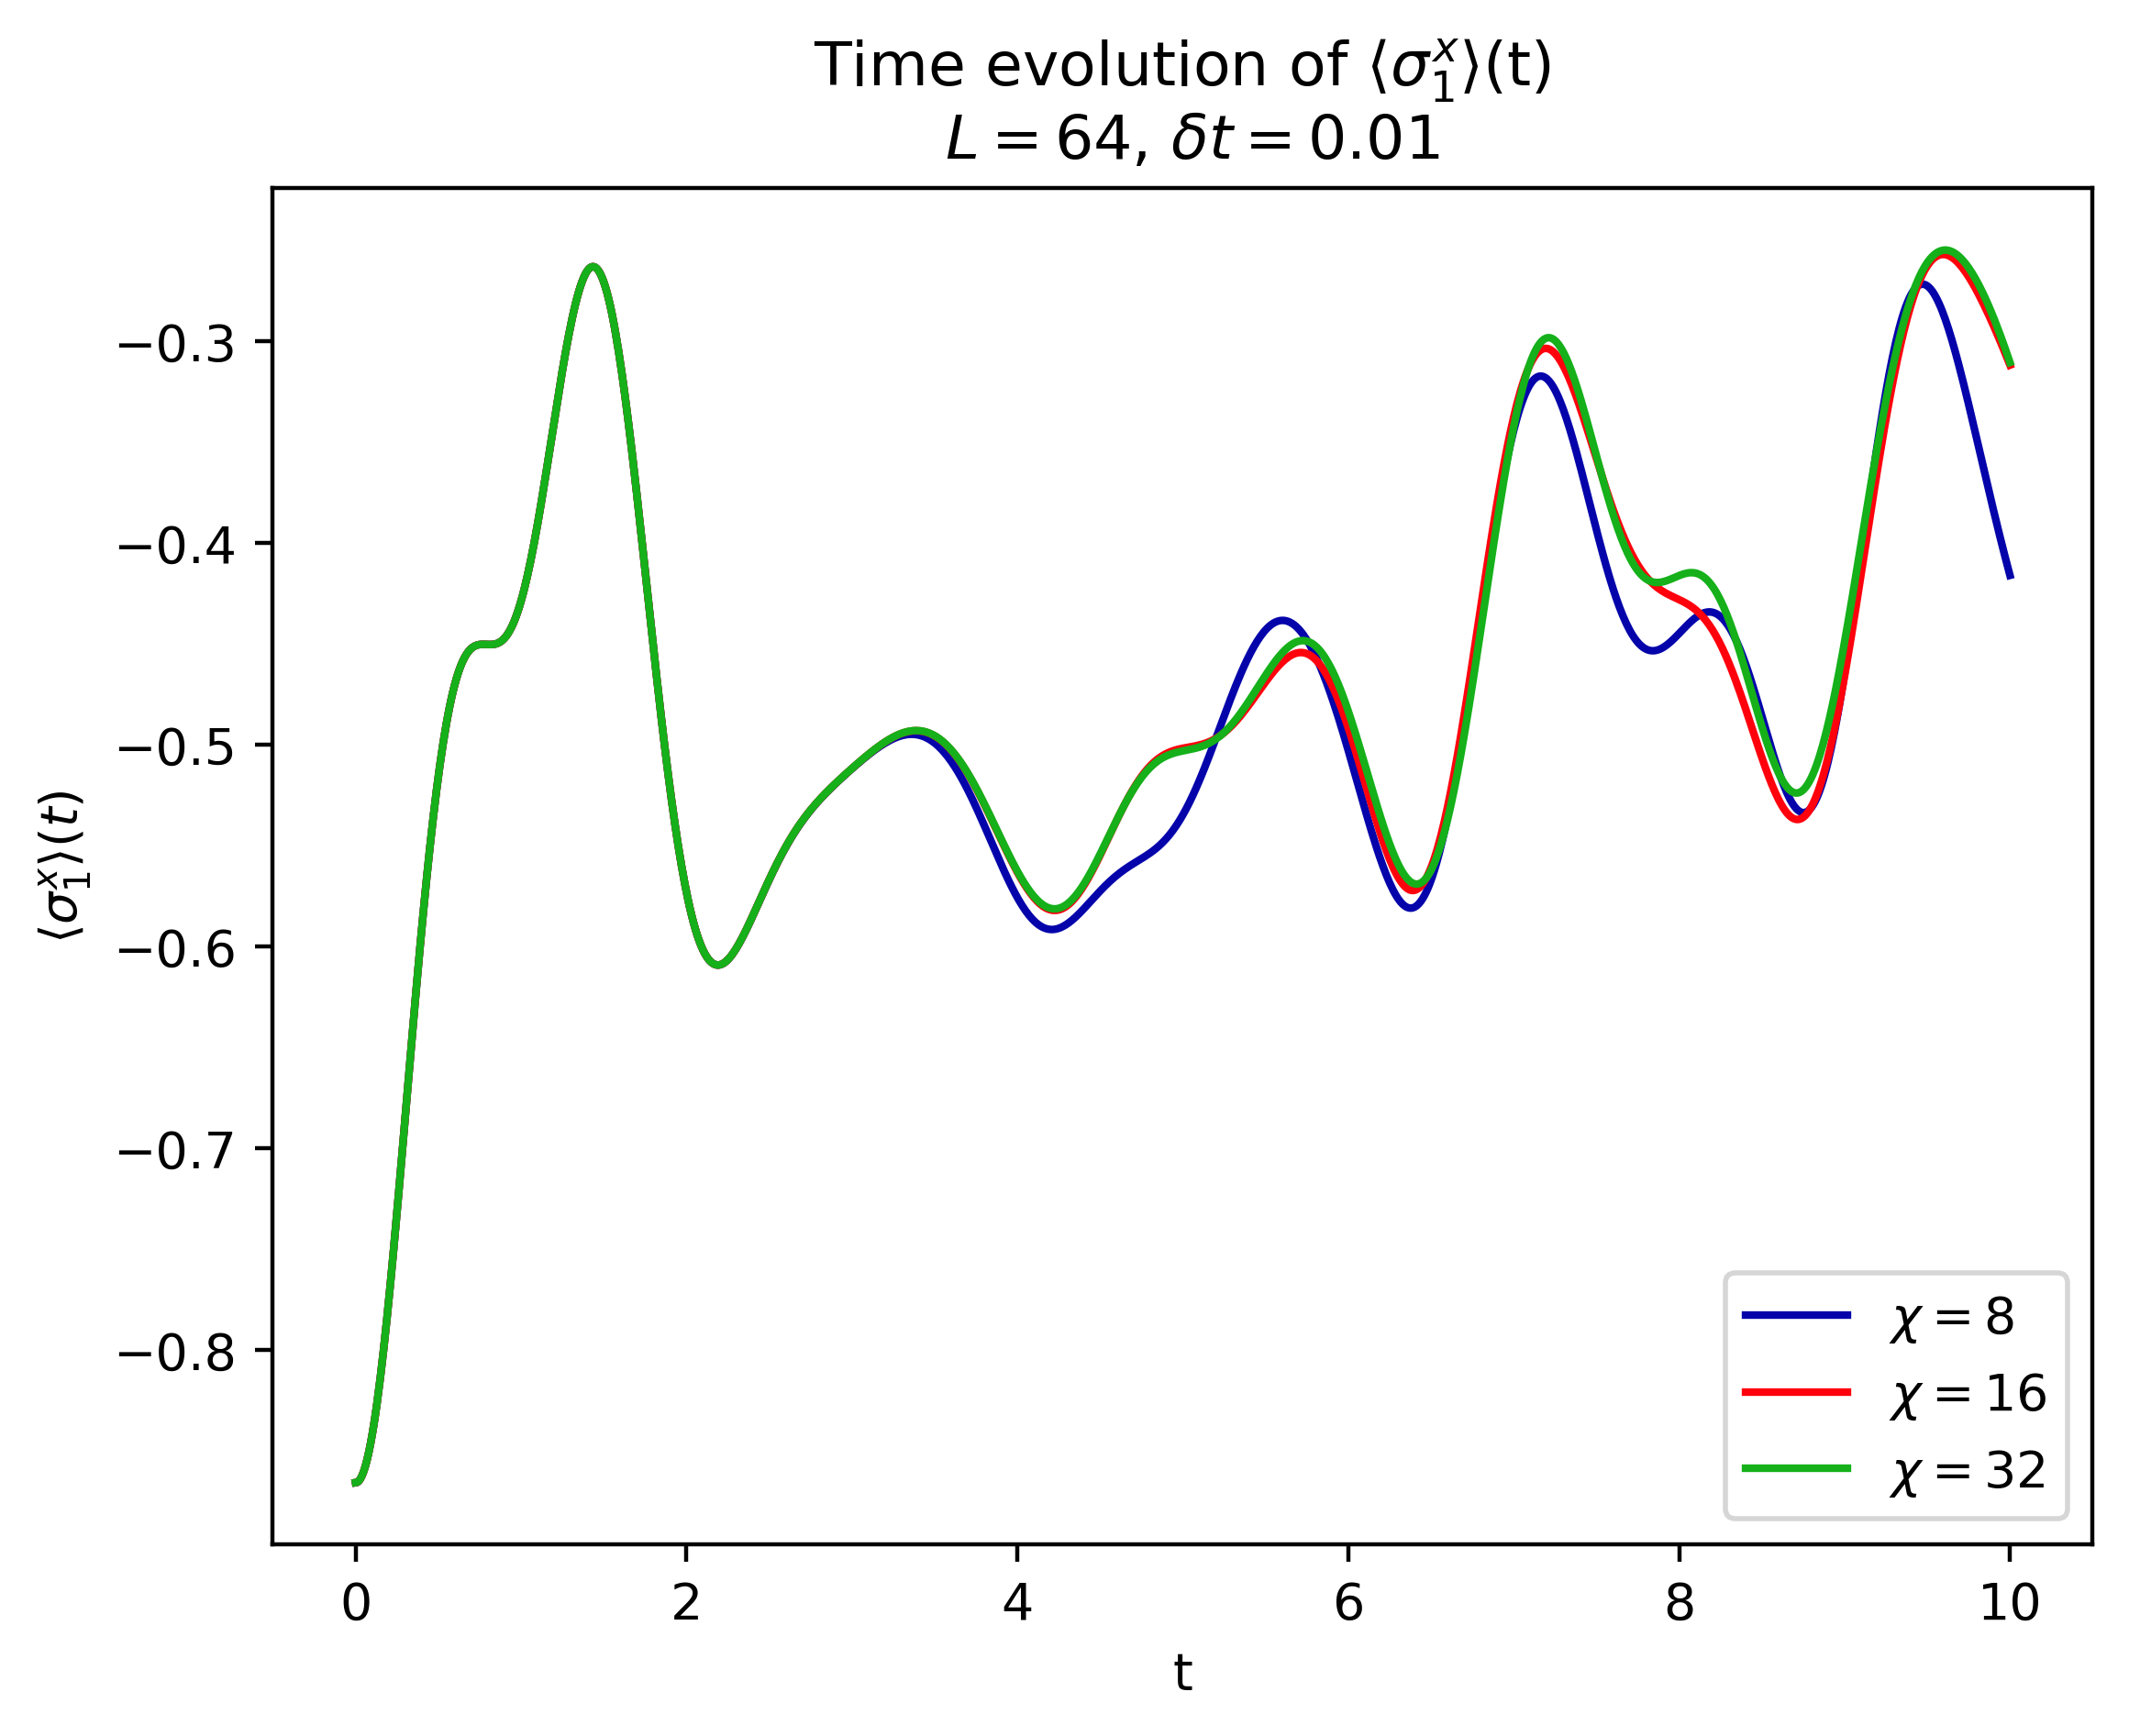

In [36]:
observables = []
observables_2 = []
observables_3 = []
for i in range(len(canonical_trackers)):
    observable = expectation_value_Cx(1, canonical_trackers[i])
    observables.append(observable)
    
    observable = expectation_value_Cx(1, canonical_trackers2[i])
    observables_2.append(observable)

    observable = expectation_value_Cx(1, canonical_trackers3[i])
    observables_3.append(observable)

plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_3, color='xkcd:royal blue', label=r'$\chi=8$')  
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables, color='xkcd:bright red', label=r'$\chi=16$')
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_2, color='xkcd:green', label=r'$\chi=32$')
         
plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^x_{1}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^x_{1}\rangle$(t)'+'\n $L = 64$, $\delta t = 0.01$')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmaxp2new.png'), dpi=400)
plt.show()

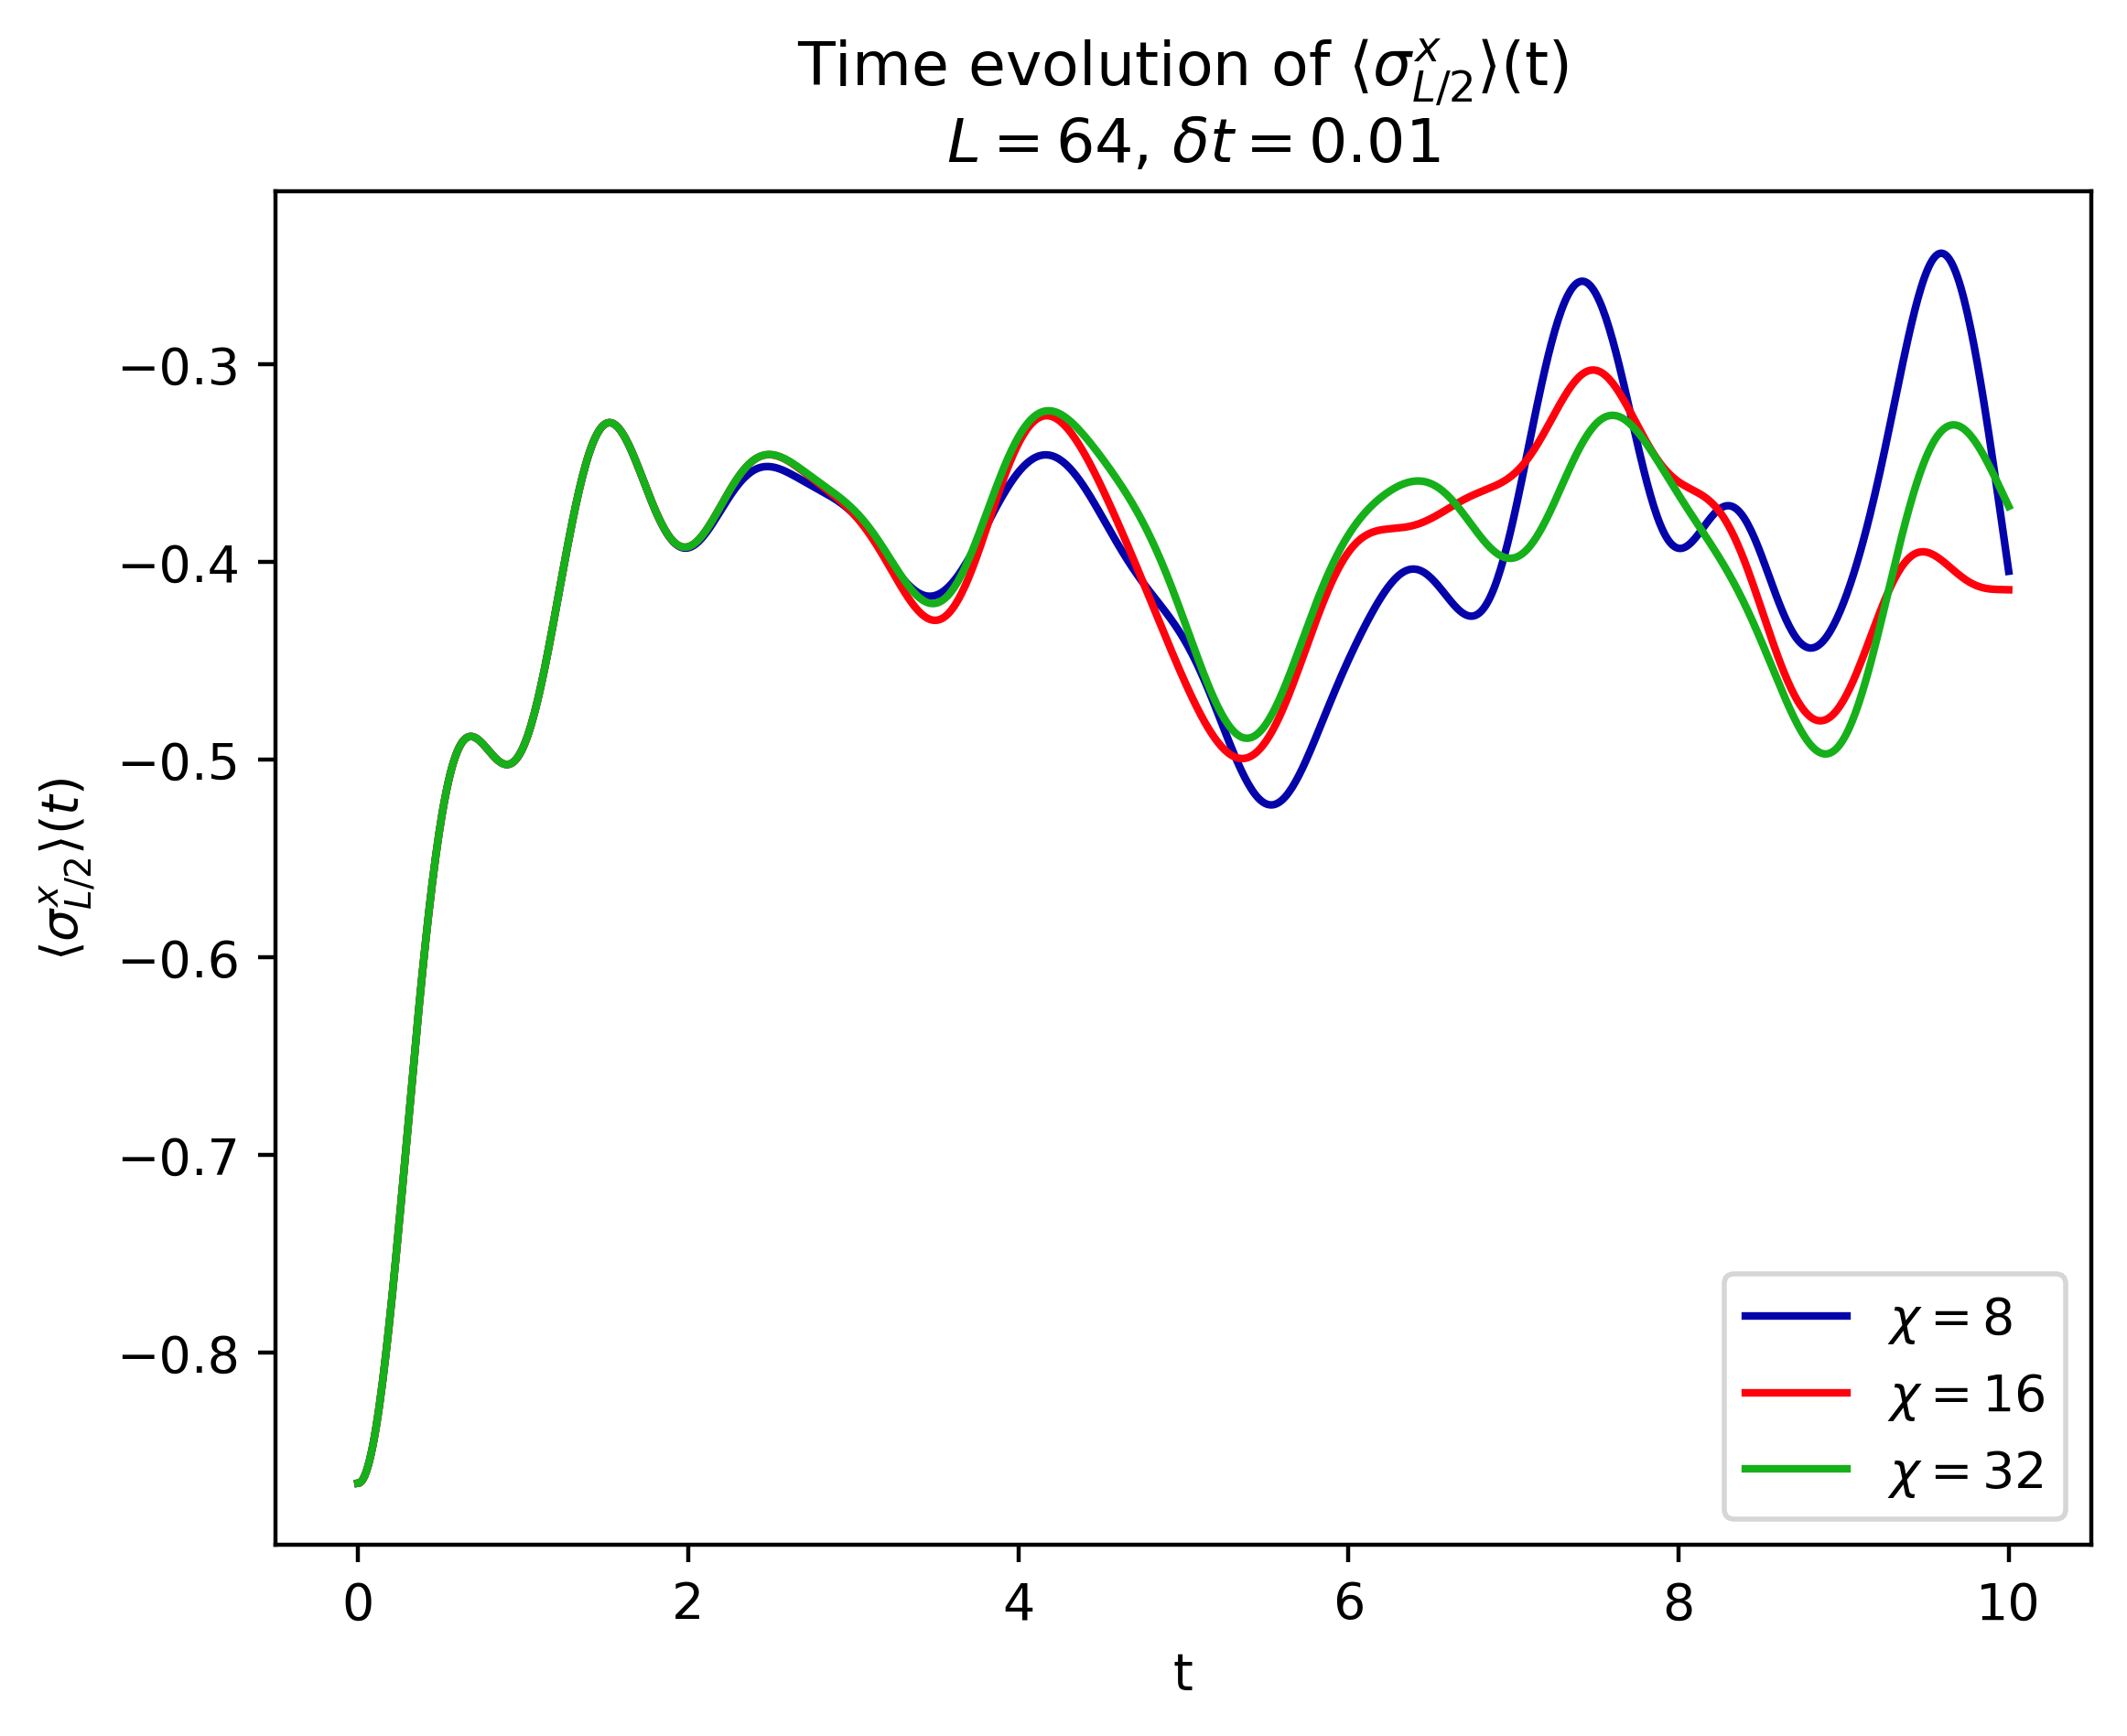

In [39]:
observables = []
observables_2 = []
observables_3 = []
for i in range(len(canonical_trackers)):
    observable = expectation_value_Cx(L//2, canonical_trackers[i])
    observables.append(observable)
    
    observable = expectation_value_Cx(L//2, canonical_trackers2[i])
    observables_2.append(observable)

    observable = expectation_value_Cx(L//2, canonical_trackers3[i])
    observables_3.append(observable)

    

plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_3, color='xkcd:royal blue', label=r'$\chi=8$')  
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables, color='xkcd:bright red', label=r'$\chi=16$')
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, observables_2, color='xkcd:green', label=r'$\chi=32$')
         
plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^x_{L/2}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^x_{L/2}\rangle$(t)'+'\n $L = 64$, $\delta t = 0.01$')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmaxp2middlenew.png'), dpi=400)
plt.show()

In [23]:
def entanglement_entropy(l, canonical_tracker):
    s = canonical_tracker[l][1]
    
    lambdas = s**2
    lambdas = lambdas/np.sum(lambdas)
    S = -np.sum(lambdas * np.log(lambdas))
    return S

Computing Entropies:   0%|                                                                    | 0/1001 [00:00<?, ?it/s]C:\Users\cheru\AppData\Local\Temp\ipykernel_36104\2574989919.py:6: RuntimeWarning: divide by zero encountered in log
  S = -np.sum(lambdas * np.log(lambdas))
C:\Users\cheru\AppData\Local\Temp\ipykernel_36104\2574989919.py:6: RuntimeWarning: invalid value encountered in multiply
  S = -np.sum(lambdas * np.log(lambdas))
Computing Entropies: 100%|██████████████████████████████████████████████████████| 1001/1001 [00:00<00:00, 20008.47it/s]


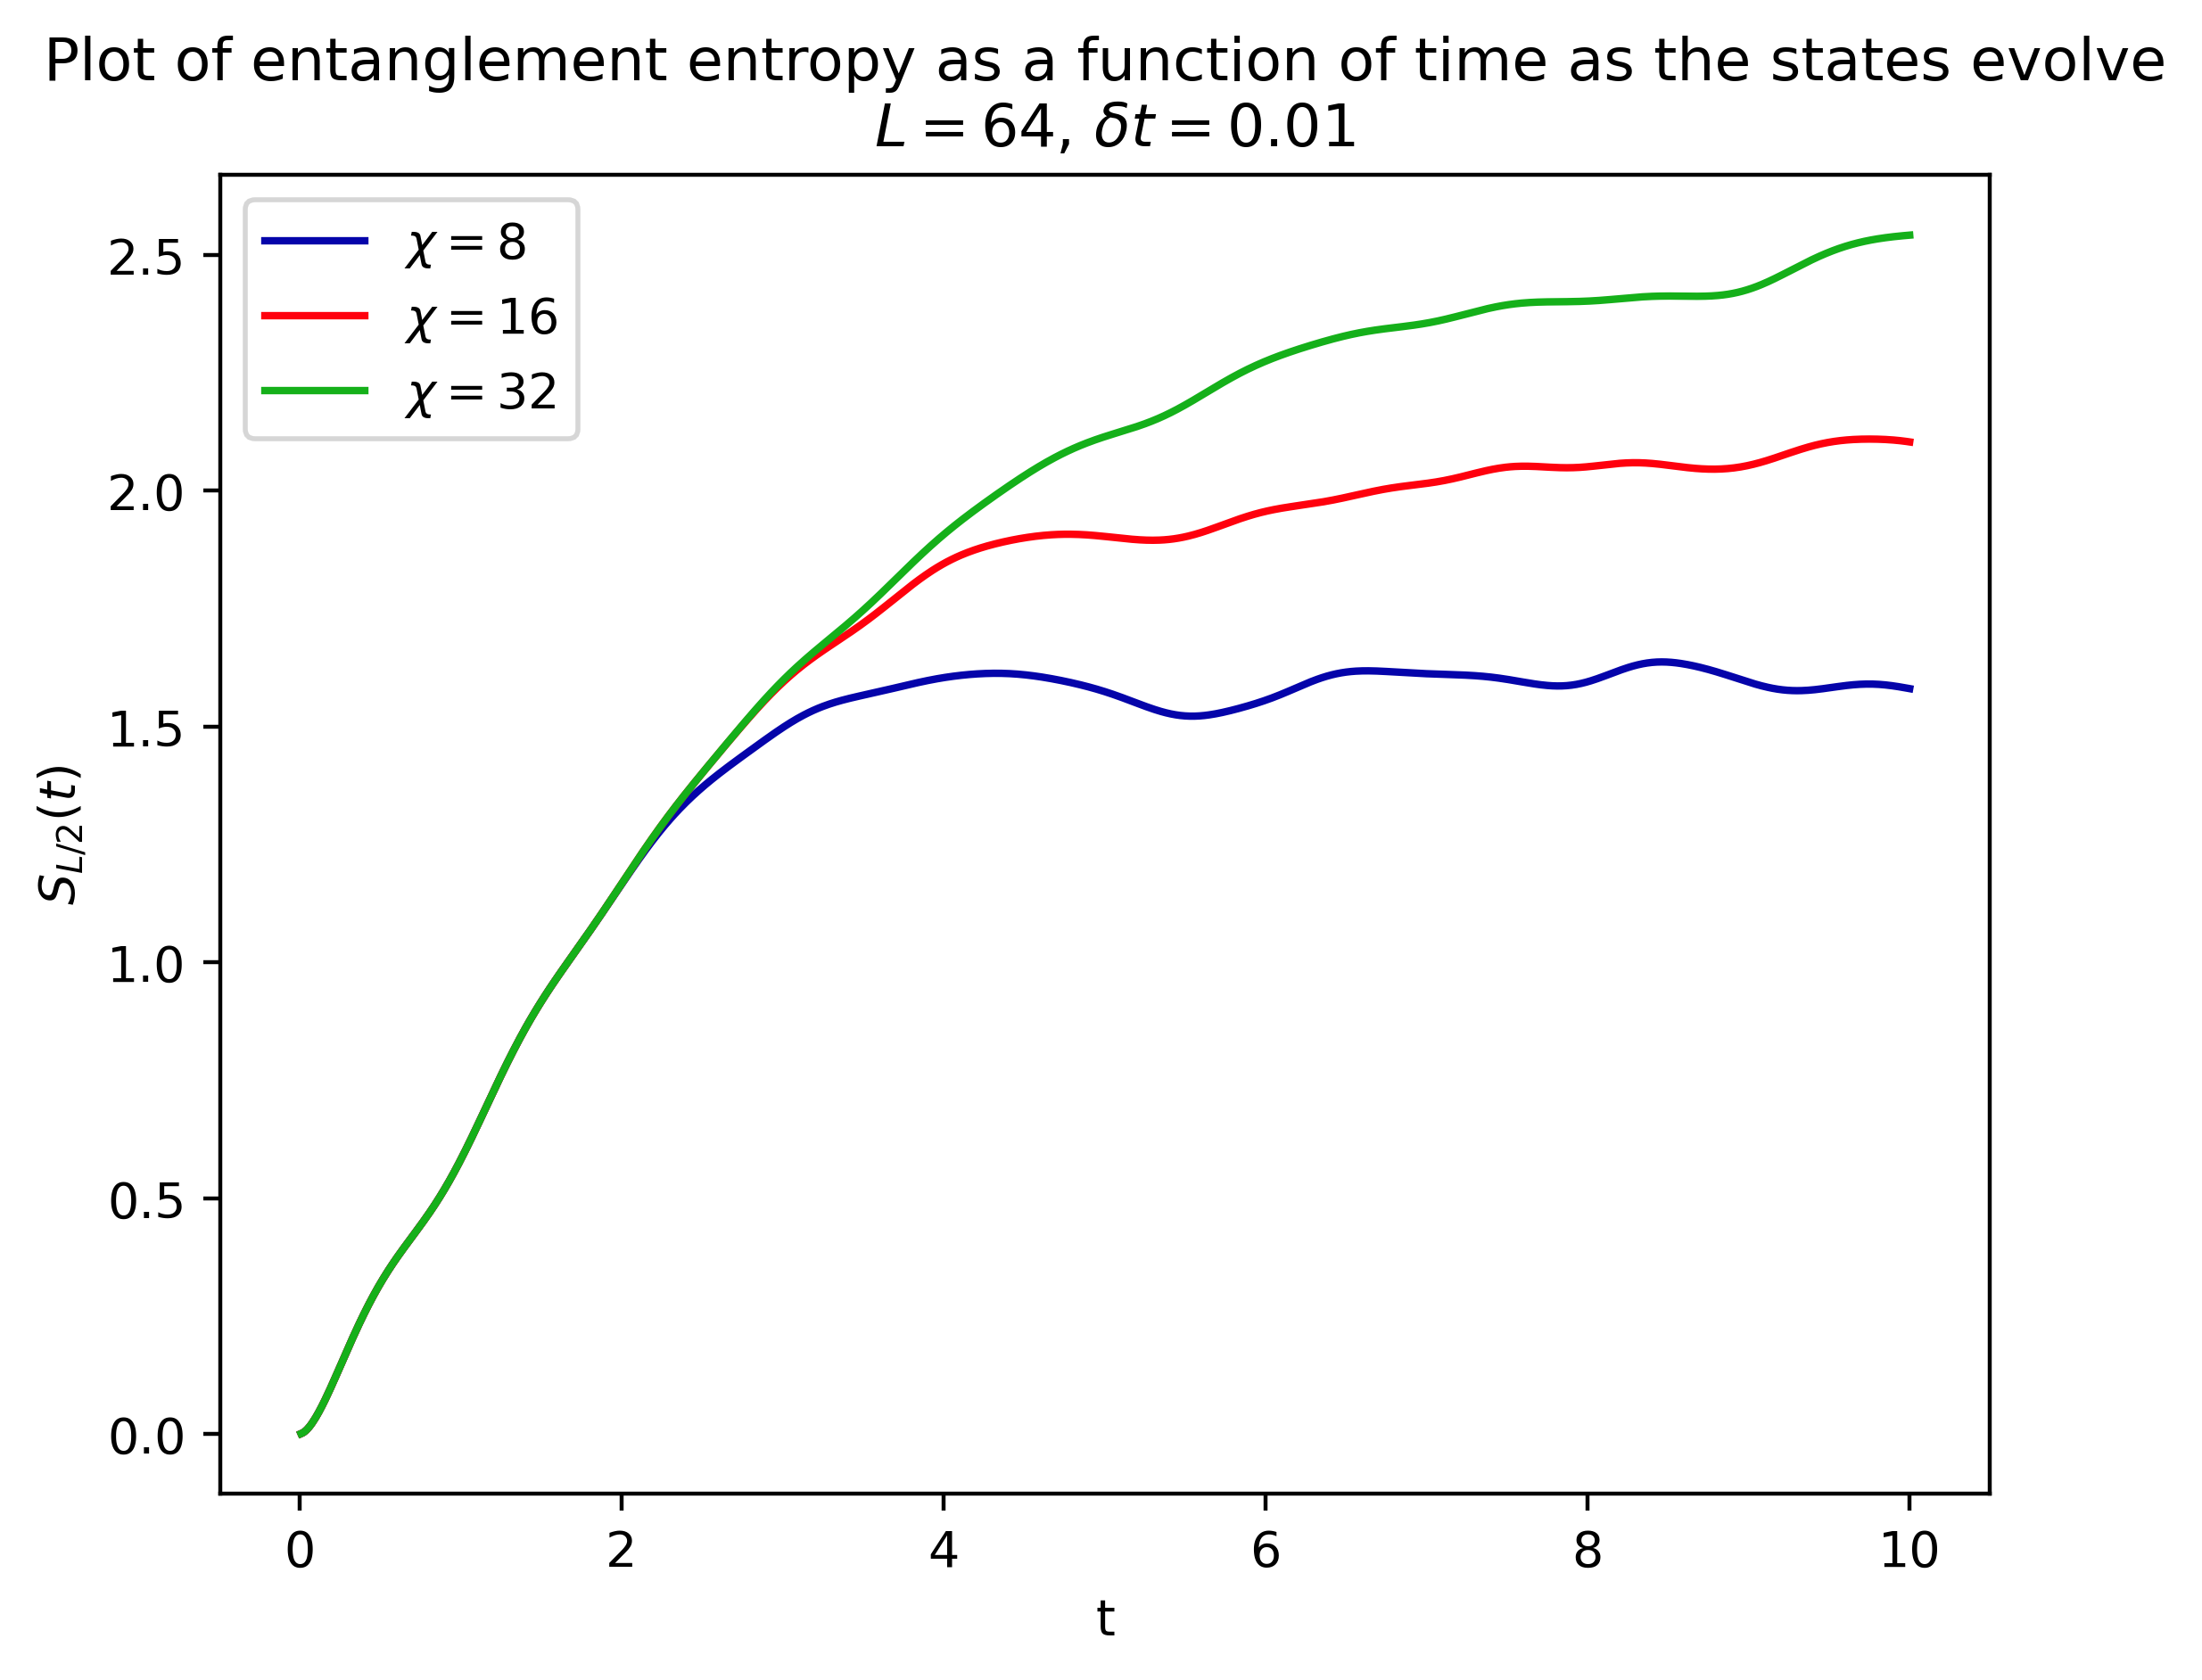

In [33]:
entropies_1 = []
entropies_2 = []
entropies_3 = []

for i in tqdm(range(len(canonical_trackers)), desc="Computing Entropies"):
    entropy = entanglement_entropy(L//2, canonical_trackers[i])
    entropies_1.append(entropy)
    
    entropy = entanglement_entropy(L//2, canonical_trackers2[i])
    entropies_2.append(entropy)
    
    entropy = entanglement_entropy(L//2, canonical_trackers3[i])
    entropies_3.append(entropy)
    

plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, entropies_3, color='xkcd:royal blue', label=r'$\chi=8$')    
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, entropies_1, color='xkcd:bright red', label=r'$\chi=16$')
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, entropies_2, color='xkcd:green', label=r'$\chi=32$')

plt.title('Plot of entanglement entropy as a function of time as the states evolve'+'\n $L = 64$, $\delta t = 0.01$')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$S_{L/2}(t)$')
plt.savefig(os.path.join(directory, 'entropyp2new.png'), dpi=400)


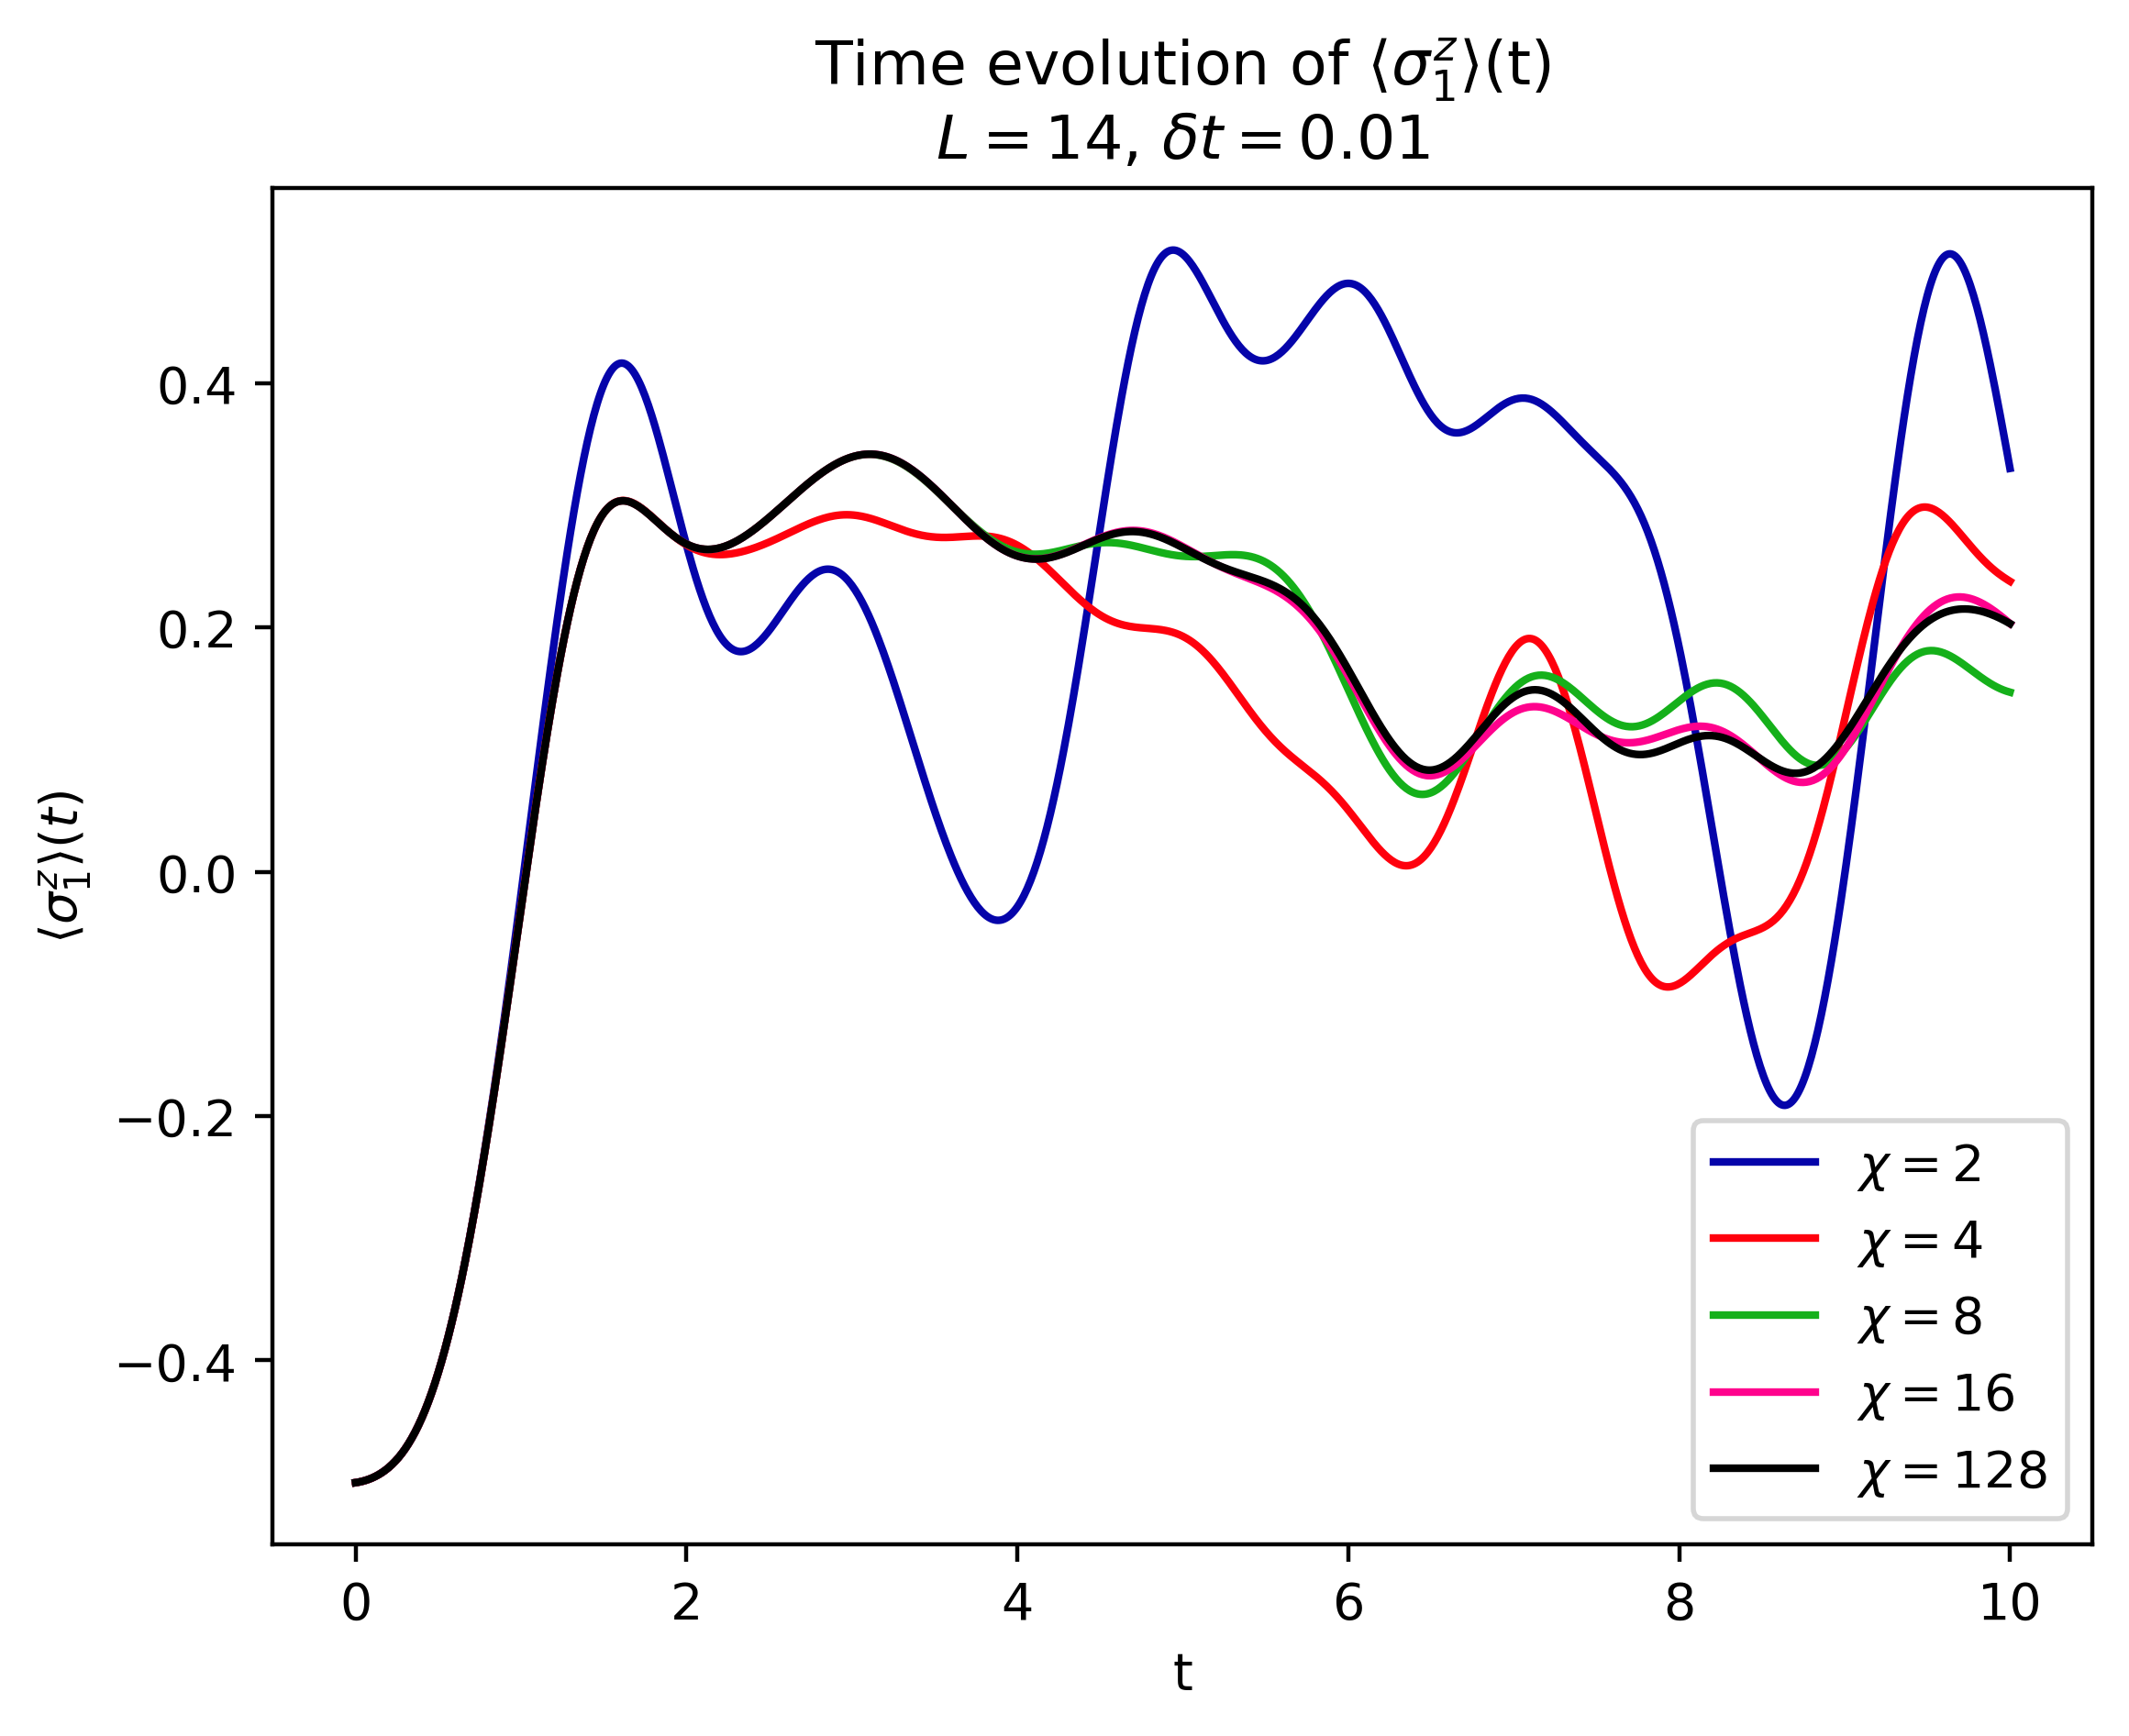

In [64]:
observables = []
observables_2 = []
observables_3 = []
observables_4 = []
observables_5 = []

for i in range(len(canonical_trackers)):
    observable = expectation_value_Cz(1, canonical_trackers51[i])
    observables.append(observable)
    
    observable = expectation_value_Cz(1, canonical_trackers61[i])
    observables_2.append(observable)

    observable = expectation_value_Cz(1, canonical_trackers1[i])
    observables_3.append(observable)

    observable = expectation_value_Cz(1, canonical_trackers41[i])
    observables_4.append(observable)

    observable = expectation_value_Cz(1, canonical_trackers71[i])
    observables_5.append(observable)
    
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_5, color='xkcd:royal blue', label=r'$\chi=2$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables, color='xkcd:bright red', label=r'$\chi=4$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_2, color='xkcd:green', label=r'$\chi=8$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_3, color='xkcd:hot pink', label=r'$\chi=16$')
# plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_4, color='xkcd:black', label=r'$\chi=32$')
# plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_3, color='xkcd:bright red', label=r'$\chi=64$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_4, color='xkcd:black', label=r'$\chi=128$')

plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^z_{1}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^z_{1}\rangle$(t)'+'\n$L = 14$, $\delta t = 0.01$')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmazp2new1.png'), dpi=400)
plt.show()

Computing observables: 100%|███████████████████████████████████████████████████████| 1001/1001 [00:36<00:00, 27.63it/s]


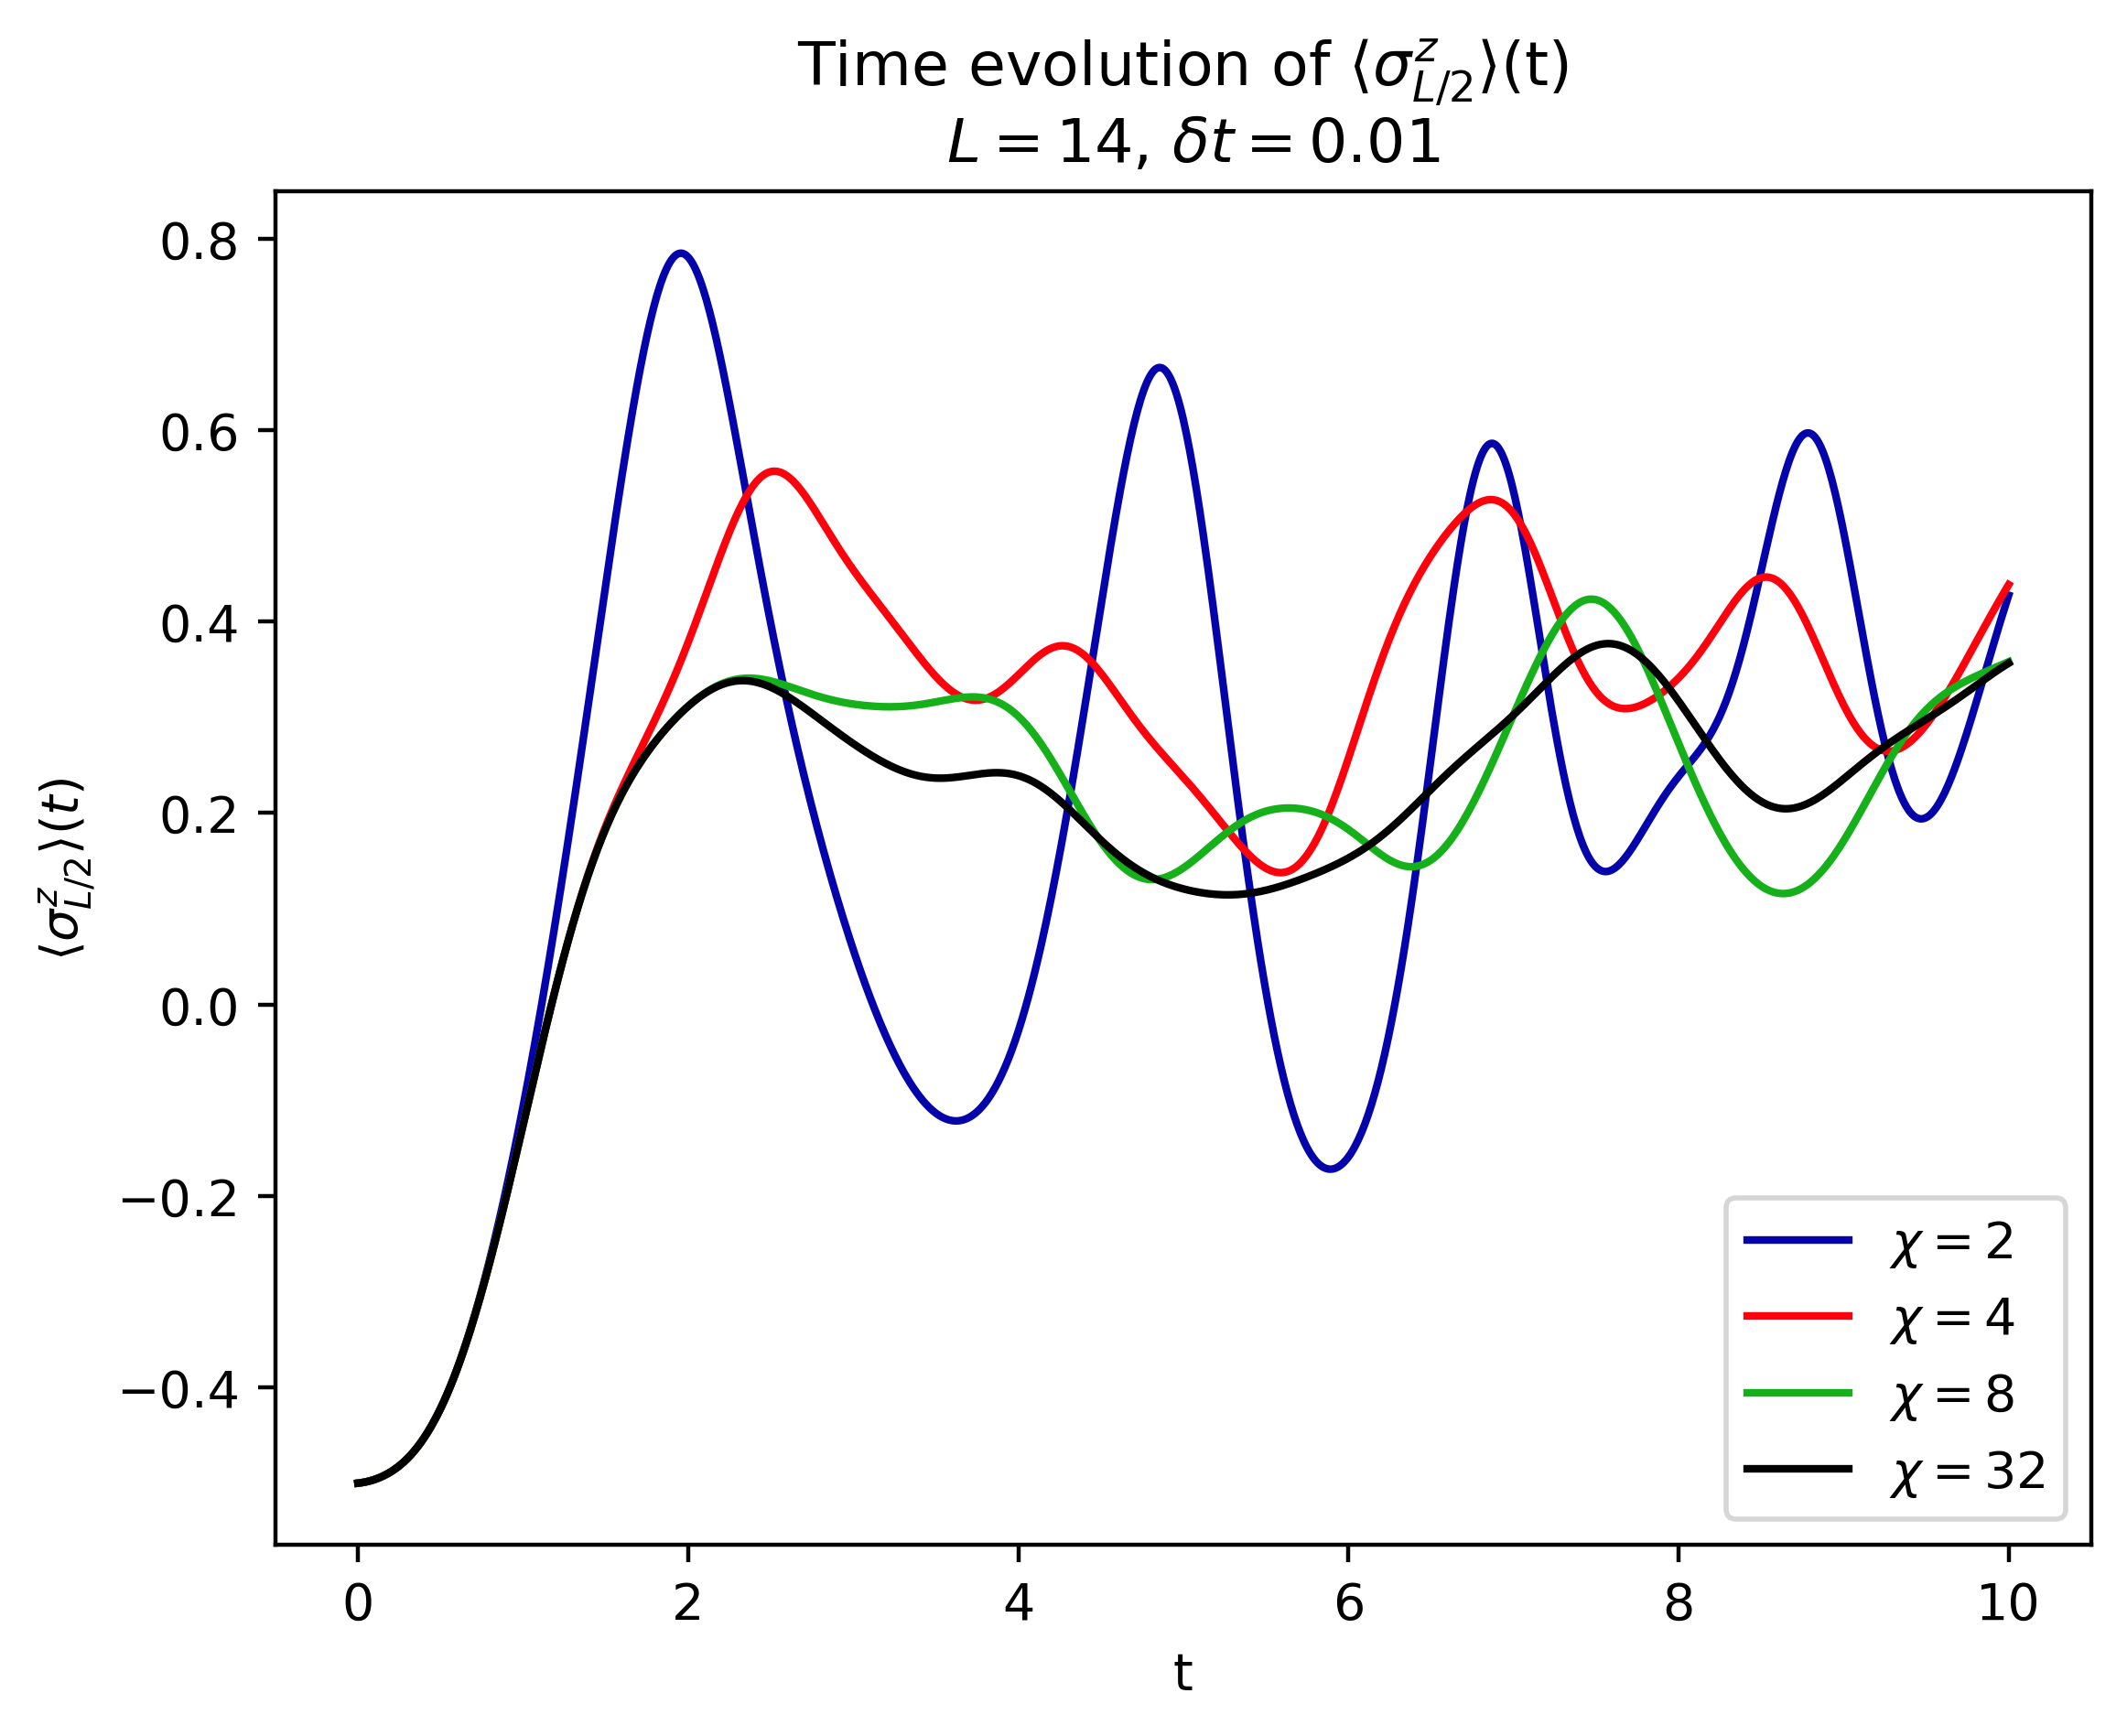

In [73]:
observables = []
observables_2 = []
observables_3 = []
# observables_4 = []
observables_5 = []

for i in tqdm(range(len(canonical_trackers)), desc="Computing observables"):
    observable = expectation_value_Cz(L//2, canonical_trackers51[i])
    observables.append(observable)
    
    observable = expectation_value_Cz(L//2, canonical_trackers61[i])
    observables_2.append(observable)

    observable = expectation_value_Cz(L//2, canonical_trackers21[i])
    observables_3.append(observable)

    # observable = expectation_value_Cz(L//2, canonical_trackers41[i])
    # observables_4.append(observable)

    observable = expectation_value_Cz(L//2, canonical_trackers71[i])
    observables_5.append(observable)
    
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_5, color='xkcd:royal blue', label=r'$\chi=2$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables, color='xkcd:bright red', label=r'$\chi=4$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_2, color='xkcd:green', label=r'$\chi=8$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_3, color='xkcd:black', label=r'$\chi=32$')
# plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_4, color='xkcd:black', label=r'$\chi=128$')

plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^z_{L/2}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^z_{L/2}\rangle$(t)'+'\n $L = 14$, $\delta t = 0.01$')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmazp2middlenew1.png'), dpi=400)
plt.show()

Computing observables: 100%|█████████████████████████████████████████████████████| 1001/1001 [00:00<00:00, 5040.40it/s]


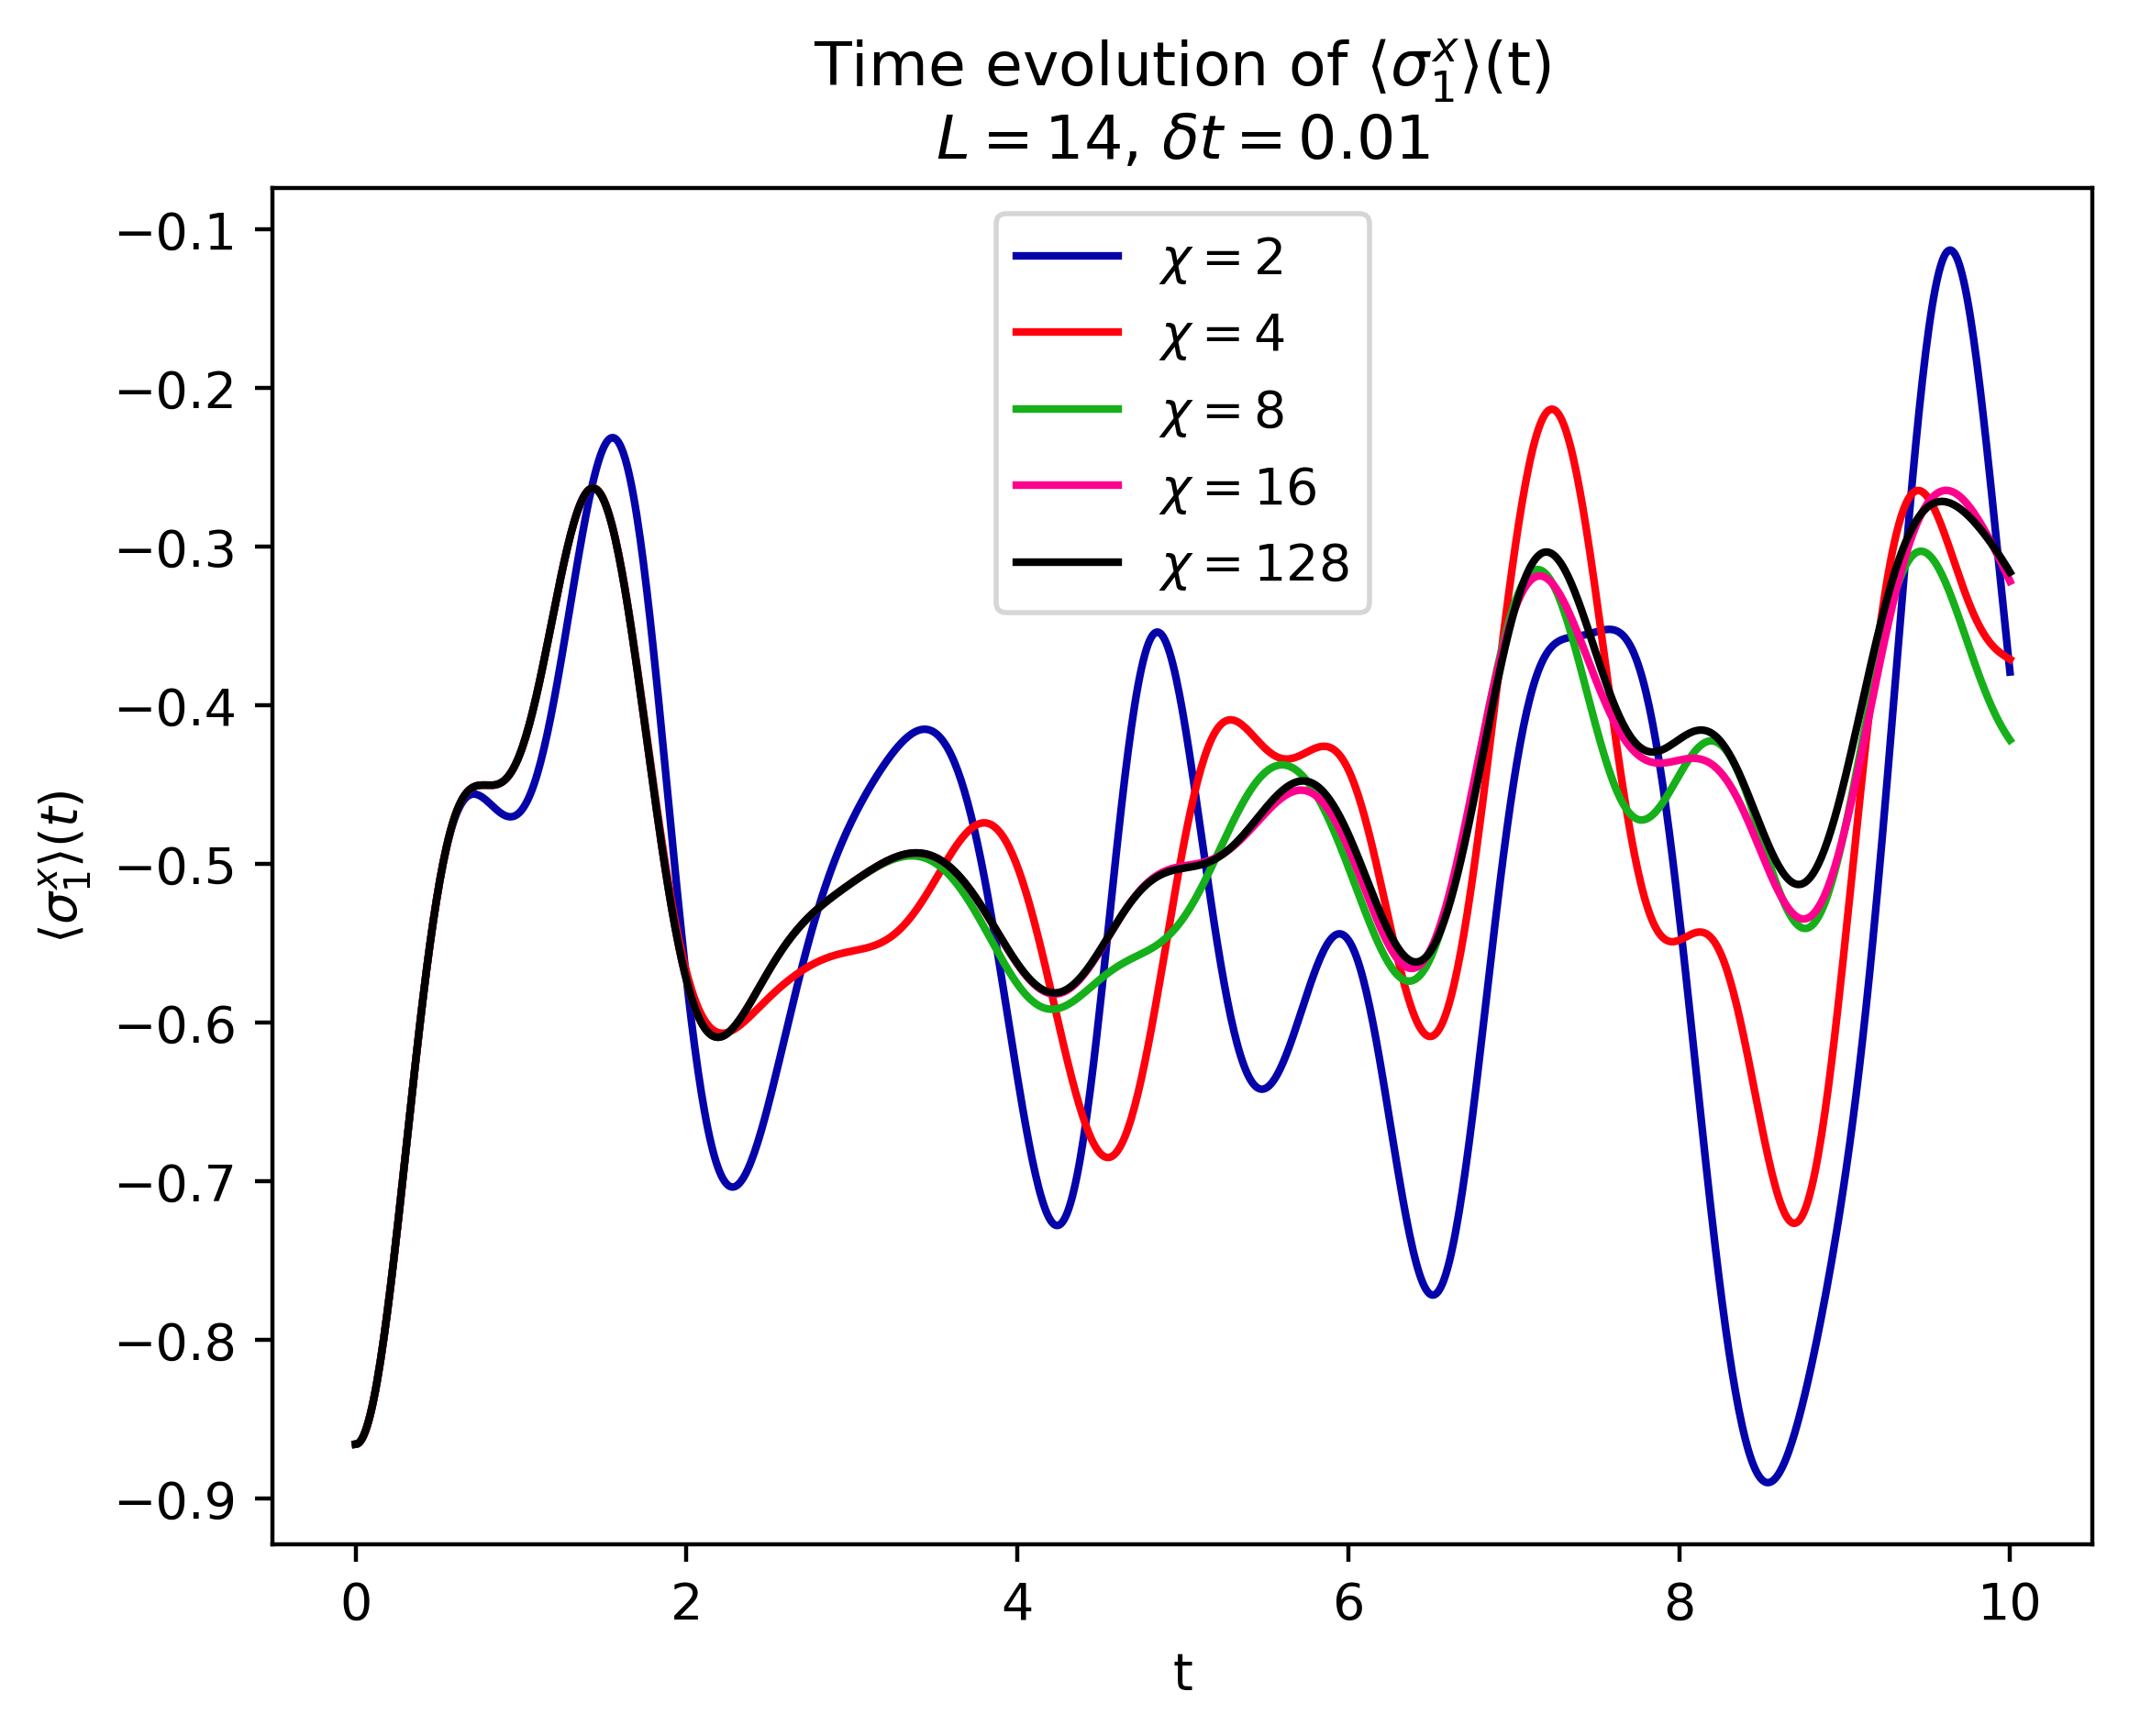

In [70]:
observables = []
observables_2 = []
observables_3 = []
observables_4 = []
observables_5 = []

for i in tqdm(range(len(canonical_trackers)), desc="Computing observables"):
    observable = expectation_value_Cx(1, canonical_trackers51[i])
    observables.append(observable)
    
    observable = expectation_value_Cx(1, canonical_trackers61[i])
    observables_2.append(observable)

    observable = expectation_value_Cx(1, canonical_trackers1[i])
    observables_3.append(observable)

    observable = expectation_value_Cx(1, canonical_trackers41[i])
    observables_4.append(observable)

    observable = expectation_value_Cx(1, canonical_trackers71[i])
    observables_5.append(observable)
    
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_5, color='xkcd:royal blue', label=r'$\chi=2$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables, color='xkcd:bright red', label=r'$\chi=4$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_2, color='xkcd:green', label=r'$\chi=8$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_3, color='xkcd:hot pink', label=r'$\chi=16$')
# plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_4, color='xkcd:black', label=r'$\chi=32$')
# plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_3, color='xkcd:bright red', label=r'$\chi=64$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_4, color='xkcd:black', label=r'$\chi=128$')

plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^x_{1}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^x_{1}\rangle$(t)'+'\n$L = 14$, $\delta t = 0.01$')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmaxp2new1.png'), dpi=400)
plt.show()

Computing observables: 100%|███████████████████████████████████████████████████████| 1001/1001 [00:40<00:00, 24.53it/s]


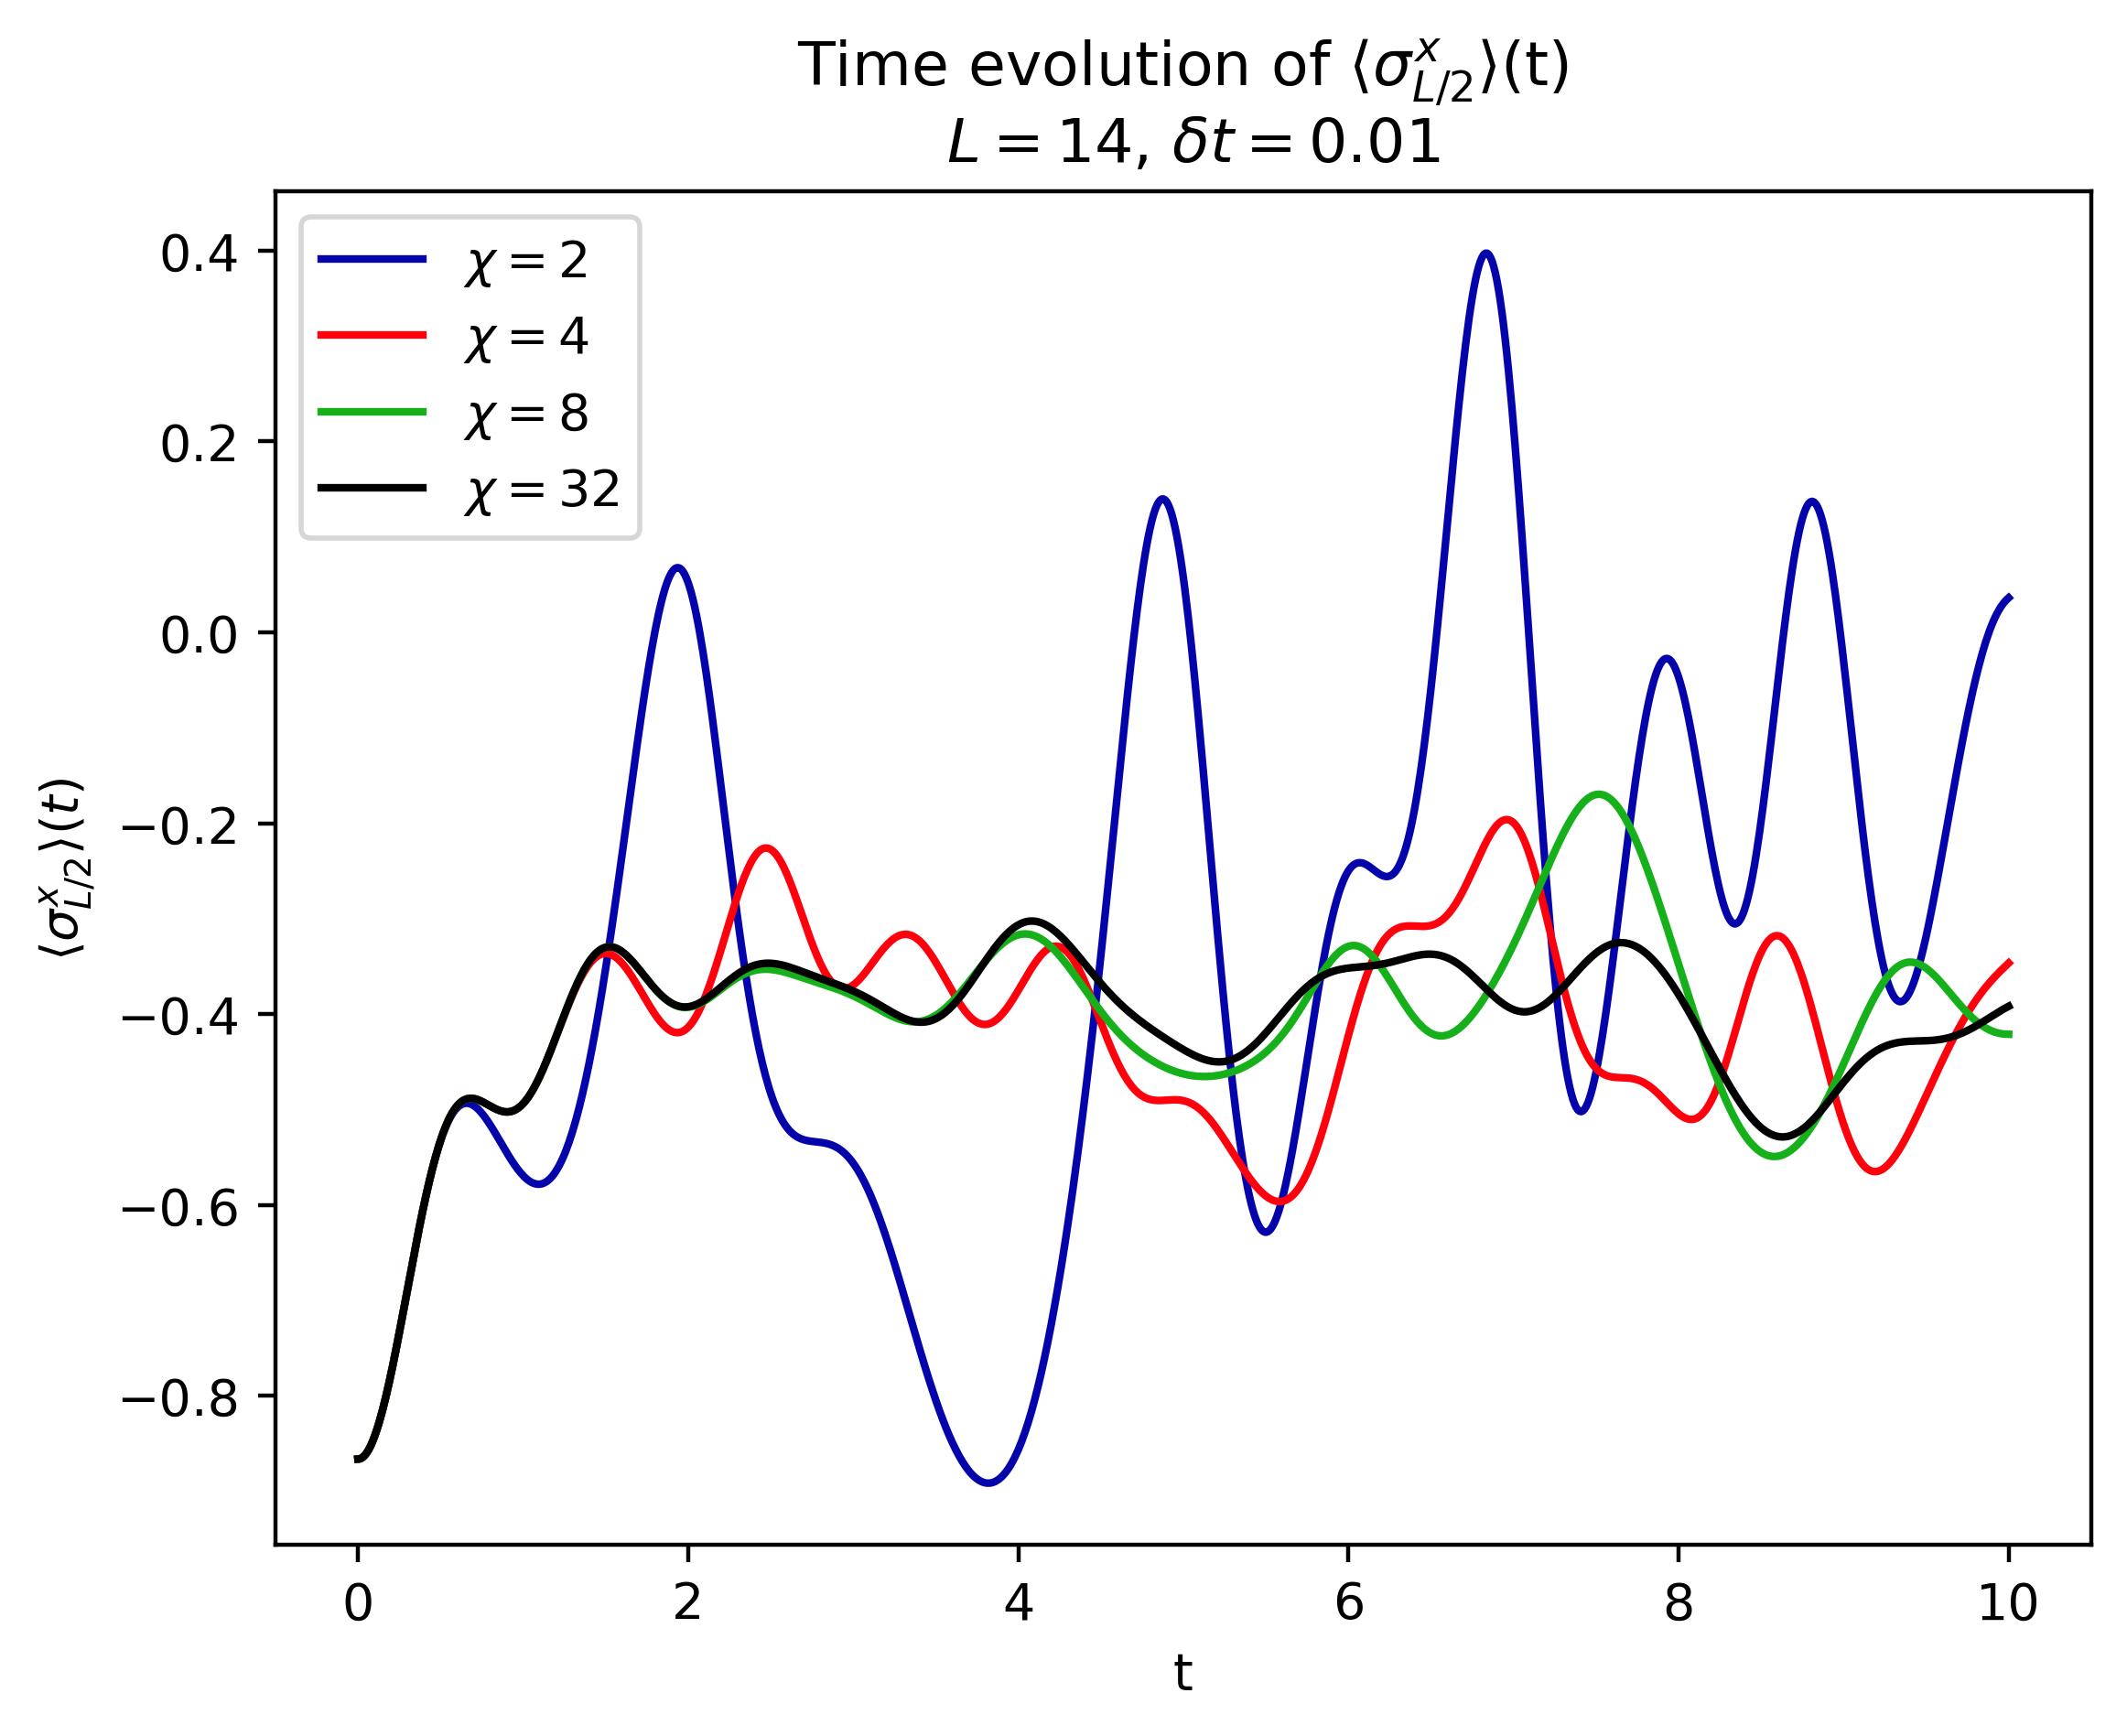

In [76]:
observables = []
observables_2 = []
observables_3 = []
# observables_4 = []
observables_5 = []

for i in tqdm(range(len(canonical_trackers)), desc="Computing observables"):
    observable = expectation_value_Cx(L//2, canonical_trackers51[i])
    observables.append(observable)
    
    observable = expectation_value_Cx(L//2, canonical_trackers61[i])
    observables_2.append(observable)

    observable = expectation_value_Cx(L//2, canonical_trackers21[i])
    observables_3.append(observable)

    # observable = expectation_value_Cz(L//2, canonical_trackers41[i])
    # observables_4.append(observable)

    observable = expectation_value_Cx(L//2, canonical_trackers71[i])
    observables_5.append(observable)
    
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_5, color='xkcd:royal blue', label=r'$\chi=2$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables, color='xkcd:bright red', label=r'$\chi=4$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_2, color='xkcd:green', label=r'$\chi=8$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, observables_3, color='xkcd:black', label=r'$\chi=32$')


plt.xlabel('t')
plt.ylabel(r'$\langle\sigma^x_{L/2}\rangle(t)$')
plt.title(r'Time evolution of $\langle\sigma^x_{L/2}\rangle$(t)'+'\n $L = 14$, $\delta t = 0.01$')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmaxp2middlenew1.png'), dpi=400)
plt.show()

Computing Entropies: 100%|███████████████████████████████████████████████████████| 1001/1001 [00:00<00:00, 9483.29it/s]


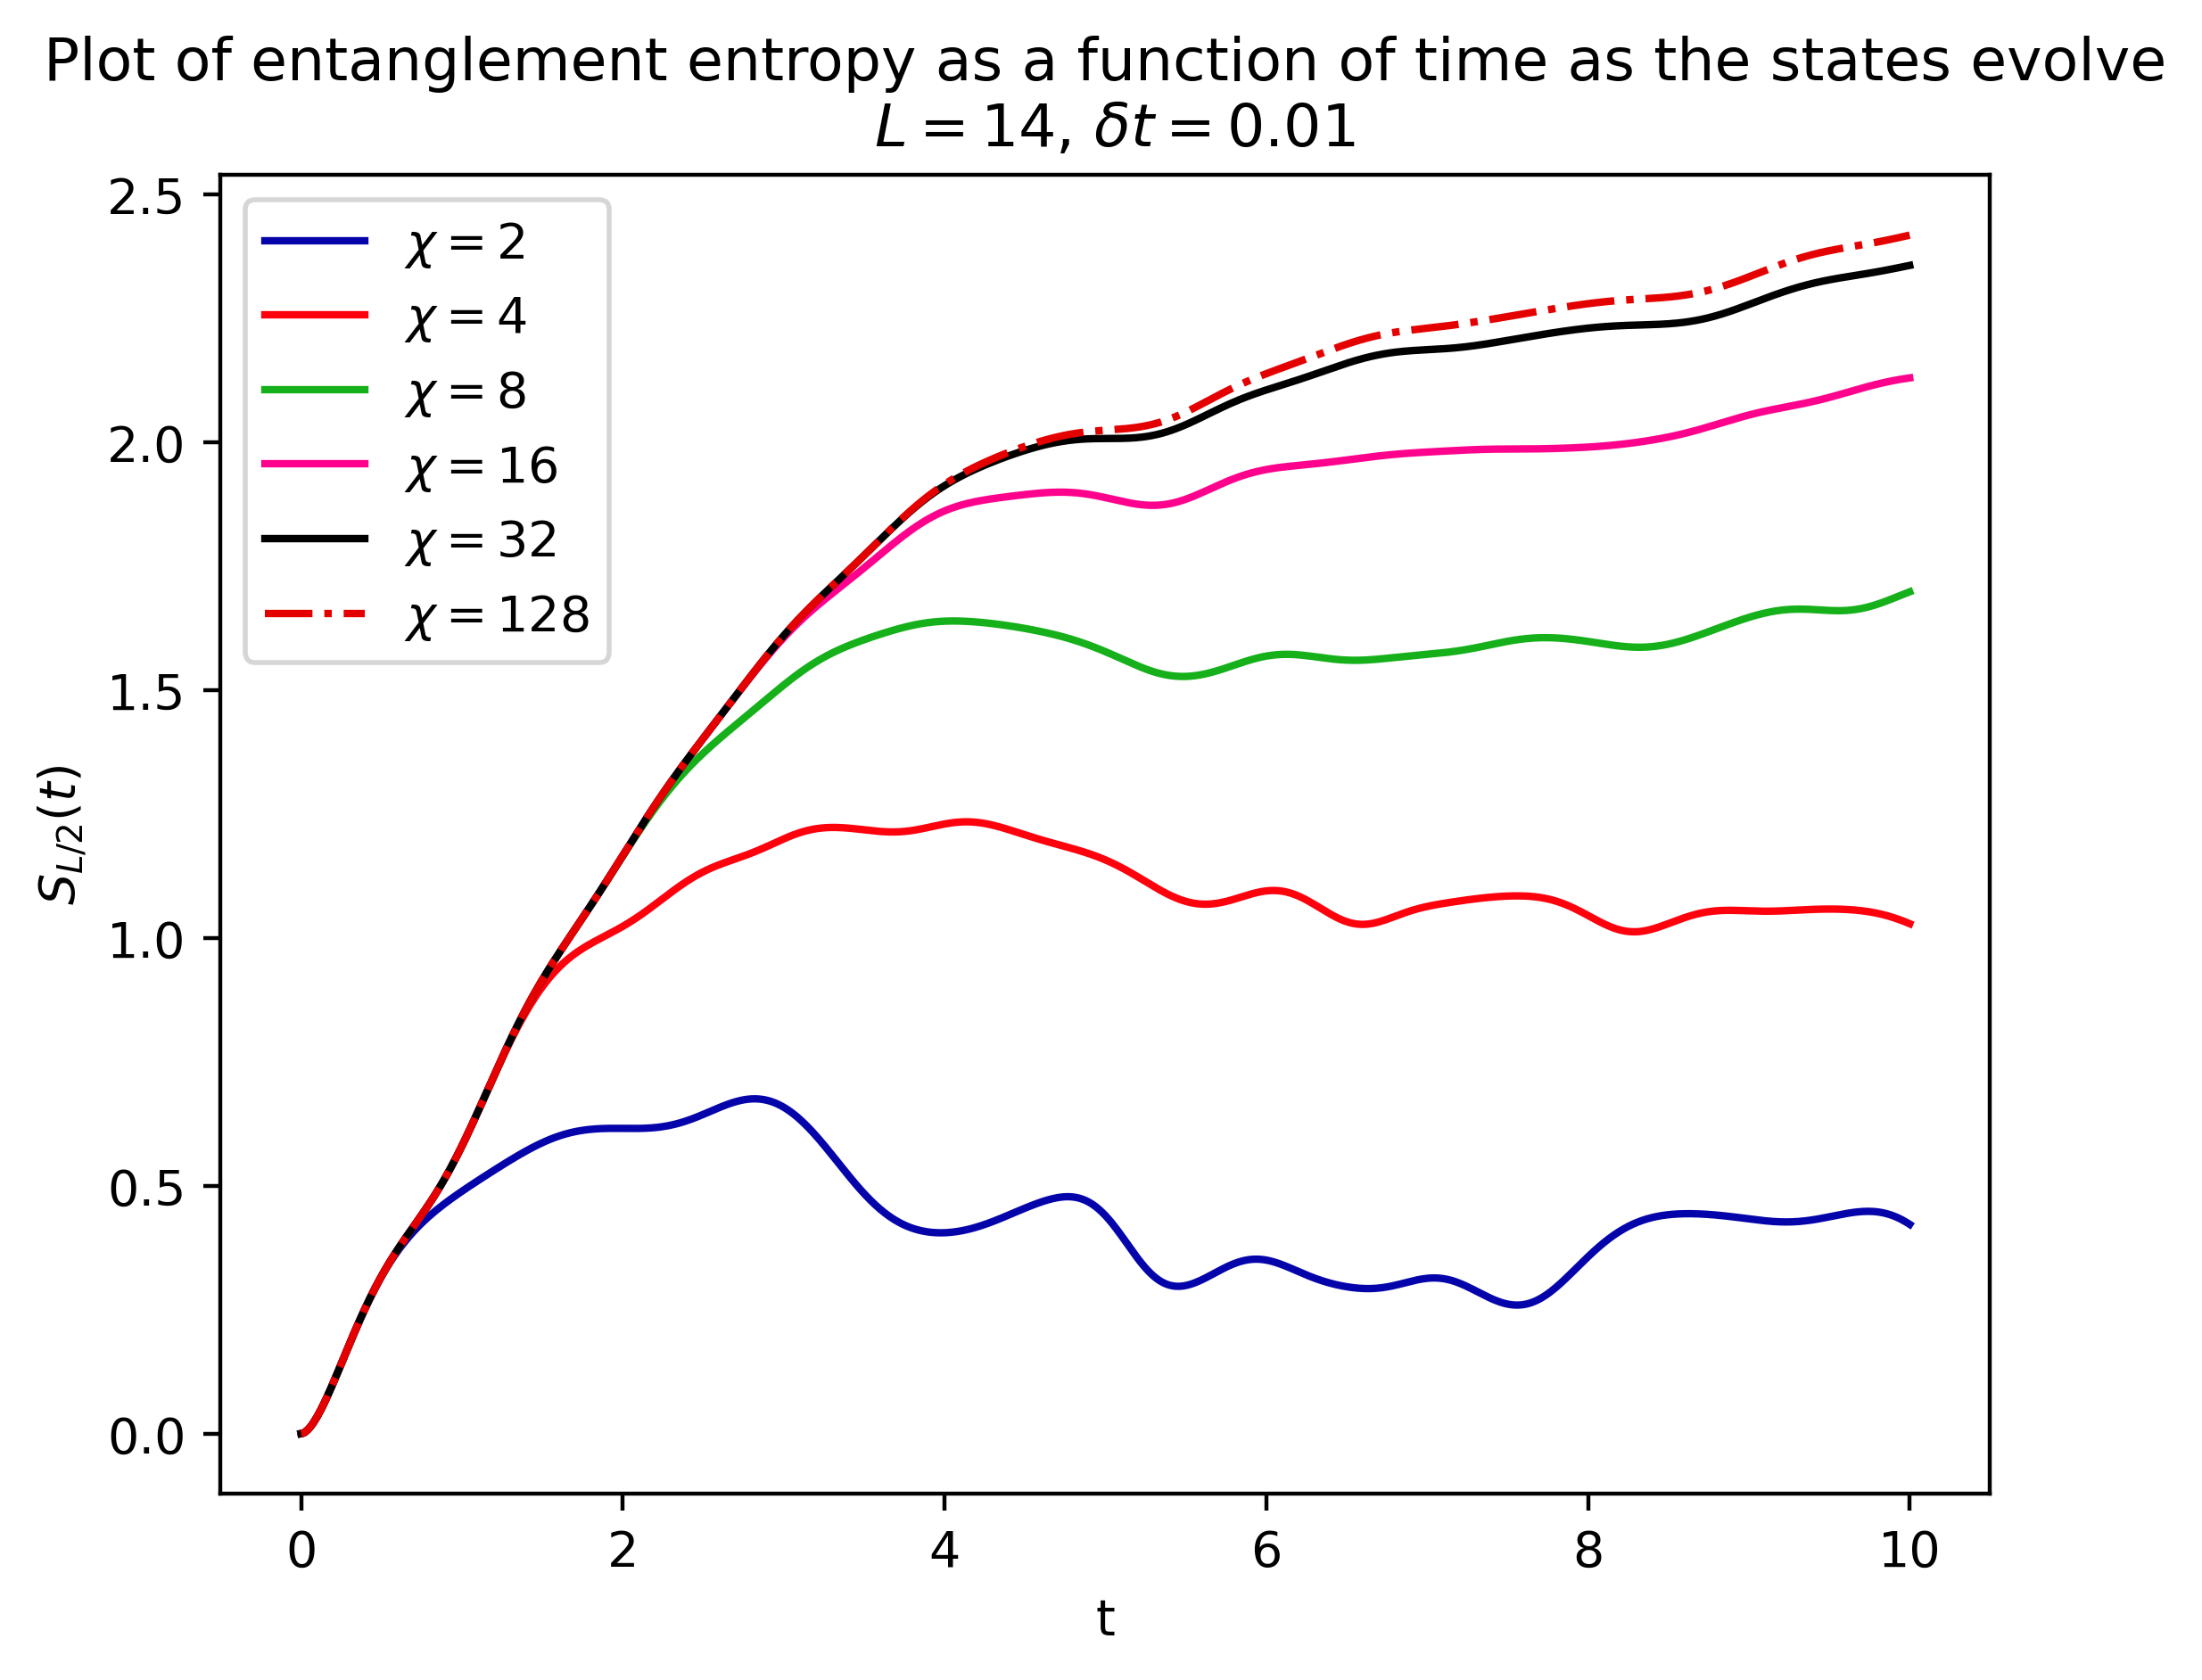

In [75]:
entropies_1 = []
entropies_2 = []
entropies_3 = []
entropies_4 = []
entropies_5 = []
entropies_6 = []

for i in tqdm(range(len(canonical_trackers)), desc="Computing Entropies"):
    entropy = entanglement_entropy(L//2, canonical_trackers51[i])
    entropies_1.append(entropy)
    
    entropy = entanglement_entropy(L//2, canonical_trackers61[i])
    entropies_2.append(entropy)
    
    entropy = entanglement_entropy(L//2, canonical_trackers1[i])
    entropies_3.append(entropy)

    entropy = entanglement_entropy(L//2, canonical_trackers21[i])
    entropies_4.append(entropy)
    
    entropy = entanglement_entropy(L//2, canonical_trackers71[i])
    entropies_5.append(entropy)

    entropy = entanglement_entropy(L//2, canonical_trackers41[i])
    entropies_6.append(entropy)
    
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt,  entropies_5, color='xkcd:royal blue', label=r'$\chi=2$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, entropies_1, color='xkcd:bright red', label=r'$\chi=4$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, entropies_2, color='xkcd:green', label=r'$\chi=8$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, entropies_3, color='xkcd:hot pink', label=r'$\chi=16$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, entropies_4, color='xkcd:black', label=r'$\chi=32$')
plt.plot(np.arange(0, len(canonical_trackers1), 1)*dt, entropies_6, color='xkcd:red', label=r'$\chi=128$', linestyle = 'dashdot')

plt.title('Plot of entanglement entropy as a function of time as the states evolve'+'\n $L = 14$, $\delta t = 0.01$')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$S_{L/2}(t)$')
plt.savefig(os.path.join(directory, 'entropyp2new1.png'), dpi=400)


In [ ]:
def neel_state_MPS(L):
    
    # given L, returns the MPS tensors of the ferromagnetic state.
    
    mps_tensors= []
    
    Aeven = np.zeros((1, 2, 1), dtype = complex)
    Aeven[0, 0, 0] = 1
    Aeven[0, 1, 0] = 0

    Aodd = np.zeros((1, 2, 1), dtype = complex)
    Aodd[0, 0, 0] = 0
    Aodd[0, 1, 0] = 1
    
    for i in range(L):
        if i%2 == 0:
            mps_tensors.append(Aodd)
        if i%2 != 0:
            mps_tensors.append(Aeven)

    return mps_tensors

In [ ]:
L = 64
J = 1
hx = -1.05
hz = 0.5
periodic = False 
dt = 0.1
t = 10
chi = 16

ket = neel_state_MPS(L)
evolved_ket_neel, canonical_trackers_neel = time_evolution(t, J, hx, hz, ket, chi, int(t/dt))
evolved_ket2_neel, canonical_trackers2_neel = time_evolution(t, J, hx, hz, ket, 32, int(t/dt))
evolved_ket3_neel, canonical_trackers3_neel = time_evolution(t, J, hx, hz, ket, 64, int(t/dt))


In [ ]:
entropies_1 = []
entropies_2 = []
entropies_3 = []

for i in tqdm(range(len(canonical_trackers)), desc="Computing Entropies"):
    entropy = entanglement_entropy(L//2, canonical_trackers_neel[i])
    entropies_1.append(entropy)
    
    entropy = entanglement_entropy(L//2, canonical_trackers2_neel[i])
    entropies_2.append(entropy)
    
    entropy = entanglement_entropy(L//2, canonical_trackers3_neel[i])
    entropies_3.append(entropy)
    

    
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, entropies_1, color='xkcd:royal blue', label=r'$\chi=16$')
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, entropies_2, color='xkcd:bright red', label=r'$\chi=32$')
plt.plot(np.arange(0, len(canonical_trackers), 1)*dt, entropies_3, color='xkcd:green', label=r'$\chi=64$')

plt.title('Plot of entanglement entropy as a function of time as the states evolve'+'\n$\epsilon = 10^{-6}$, $L = 30$, $\delta t = 0.1$')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$S_{L/2}(t)$')
plt.savefig(os.path.join(directory, 'entropyp2neel.png'), dpi=400)
